# Ordering by metrics and retraining phase

## Dataset: GTSRB

## Experiment configuration 1
- Date: 27/10/2021

## Configuration
	1. Incremental guided retraining starting from scratchusing the new adversarial inputs and original train-ing set

In [ ]:
pip install --user tensorflow==2.5

In [1]:
import argparse

import numpy as np
import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2

import glob
import os
import cv2
import keras


import time
import argparse

from tqdm import tqdm

from keras.models import load_model, Model


In [2]:
tf.__version__ == '2.5.0' # Version of tensorflow

True

In [ ]:
cd '../utils'

In [3]:
# utils for project
import utils_guided_retraining as utils

In [ ]:
cd '../notebooks/'

In [4]:
dataset = "gtsrb"

In [5]:
x_train,y_train = utils.get_data(dataset,"Train")
x_val,y_val = utils.get_data(dataset,"Val")
x_test,y_test = utils.get_data(dataset,"Test")

In [6]:
x_train_and_adversary,y_train_and_adversary = utils.get_data(dataset,"Train_and_adversary")

In [7]:
x_adversary_training = x_train_and_adversary[len(x_train):]
print(len(x_adversary_training))
y_adversary_training = y_train_and_adversary[len(y_train):]

print(len(y_adversary_training))

5000
5000


In [8]:
# Obtaining adversarial examples for testing 
x_test_and_adversary,y_test_and_adversary = utils.get_adversarial_data(dataset,'Test_fgsm') 

In [9]:
x_adversary_test_fgsm = x_test_and_adversary[len(x_test):]
print(len(x_adversary_test_fgsm))
y_adversary_test_fgsm = y_test_and_adversary[len(y_test):]

print(len(y_adversary_test_fgsm))

3923
3923


## ----

In [10]:
# Original model 
model_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06"


In [11]:
model_original = utils.My_model(dataset,True, model_dir)

Model loaded correctly


## Obtaining new LSA and DSA values 

In [11]:
save_dir_lsa = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/lsa_values_1.npy"
 
save_dir_dsa = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/dsa_values_1.npy"

target_lsa = np.load(save_dir_lsa)
target_dsa = np.load(save_dir_dsa)

In [12]:
lsa_values = target_lsa
dsa_values = target_dsa

In [13]:

# Obtaining top n images by LSA values
top_images_by_lsa = utils.get_x_of_indexes(list(np.flip(np.argsort(lsa_values))),x_train_and_adversary)
top_labels_by_lsa = utils.get_x_of_indexes(list(np.flip(np.argsort(lsa_values))),y_train_and_adversary)


In [13]:

top_images_by_dsa = utils.get_x_of_indexes(list(np.flip(np.argsort(dsa_values))),x_train_and_adversary)
top_labels_by_dsa = utils.get_x_of_indexes(list(np.flip(np.argsort(dsa_values))),y_train_and_adversary)


In [15]:
len(top_images_by_lsa)//20

1818

In [16]:
len(x_train)

31366

In [14]:
m = 1800
n = 0
image_sets_lsa = []
label_sets_lsa = []


for i in range(len(top_images_by_lsa)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_lsa)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_lsa)%m))
        top_images_by_lsa_n = np.array(top_images_by_lsa[:n+m+(len(top_images_by_lsa)%m)])
        top_labels_by_lsa_n = np.array(top_labels_by_lsa[:n+m+(len(top_images_by_lsa)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_lsa_n = np.array(top_images_by_lsa[:n+m])
        top_labels_by_lsa_n = np.array(top_labels_by_lsa[:n+m])
    image_sets_lsa.append(top_images_by_lsa_n)
    label_sets_lsa.append(top_labels_by_lsa_n)
    print(len(top_images_by_lsa_n))
    n += m



0 :
0  ->  1800
1800
1 :
0  ->  3600
3600
2 :
0  ->  5400
5400
3 :
0  ->  7200
7200
4 :
0  ->  9000
9000
5 :
0  ->  10800
10800
6 :
0  ->  12600
12600
7 :
0  ->  14400
14400
8 :
0  ->  16200
16200
9 :
0  ->  18000
18000
10 :
0  ->  19800
19800
11 :
0  ->  21600
21600
12 :
0  ->  23400
23400
13 :
0  ->  25200
25200
14 :
0  ->  27000
27000
15 :
0  ->  28800
28800
16 :
0  ->  30600
30600
17 :
0  ->  32400
32400
18 :
0  ->  34200
34200
19 :
Last
0  ->  36366
36366


## point lsa

In [15]:
print(model_dir)

models_lsa = []
for i in range(len(label_sets_lsa)):
    print(i,":")
    model = utils.My_model(dataset,False,None)
    model.compile_model()
    models_lsa.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06
0 :
Model compiled
1 :
Model compiled
2 :
Model compiled
3 :
Model compiled
4 :
Model compiled
5 :
Model compiled
6 :
Model compiled
7 :
Model compiled
8 :
Model compiled
9 :
Model compiled
10 :
Model compiled
11 :
Model compiled
12 :
Model compiled
13 :
Model compiled
14 :
Model compiled
15 :
Model compiled
16 :
Model compiled
17 :
Model compiled
18 :
Model compiled
19 :
Model compiled


In [21]:
n = 0
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n=n+1

Epoch 1/10
29/29 [==============================] - 43s 648ms/step - loss: 3.6413 - accuracy: 0.0798 - val_loss: 3.5525 - val_accuracy: 0.0574
Epoch 2/10
29/29 [==============================] - 18s 642ms/step - loss: 3.4355 - accuracy: 0.0802 - val_loss: 3.5225 - val_accuracy: 0.0788
Epoch 3/10
29/29 [==============================] - 17s 585ms/step - loss: 3.4150 - accuracy: 0.0764 - val_loss: 3.6726 - val_accuracy: 0.0684
Epoch 4/10
29/29 [==============================] - 17s 594ms/step - loss: 3.3297 - accuracy: 0.0985 - val_loss: 3.5138 - val_accuracy: 0.0628
Epoch 5/10
29/29 [==============================] - 17s 604ms/step - loss: 3.2925 - accuracy: 0.1267 - val_loss: 3.7942 - val_accuracy: 0.0709
Epoch 6/10
29/29 [==============================] - 18s 631ms/step - loss: 3.2865 - accuracy: 0.1404 - val_loss: 3.4672 - val_accuracy: 0.0791
Epoch 7/10
29/29 [==============================] - 18s 632ms/step - loss: 3.2392 - accuracy: 0.1248 - val_loss: 3.4511 - val_accuracy: 0.0911

In [22]:
n=1
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

Epoch 1/10
57/57 [==============================] - 32s 503ms/step - loss: 3.6457 - accuracy: 0.0431 - val_loss: 3.5626 - val_accuracy: 0.0528
Epoch 2/10
57/57 [==============================] - 31s 547ms/step - loss: 3.5401 - accuracy: 0.0560 - val_loss: 3.4702 - val_accuracy: 0.0901
Epoch 3/10
57/57 [==============================] - 30s 519ms/step - loss: 3.4748 - accuracy: 0.0894 - val_loss: 3.3957 - val_accuracy: 0.0906
Epoch 4/10
57/57 [==============================] - 28s 492ms/step - loss: 3.4167 - accuracy: 0.0808 - val_loss: 3.4061 - val_accuracy: 0.0916
Epoch 5/10
57/57 [==============================] - 27s 484ms/step - loss: 3.3952 - accuracy: 0.0976 - val_loss: 3.1350 - val_accuracy: 0.1388
Epoch 6/10
57/57 [==============================] - 30s 527ms/step - loss: 3.1571 - accuracy: 0.1507 - val_loss: 2.5813 - val_accuracy: 0.3034
Epoch 7/10
57/57 [==============================] - 32s 557ms/step - loss: 2.6253 - accuracy: 0.2926 - val_loss: 2.0799 - val_accuracy: 0.4294

In [23]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

2
Epoch 1/10
85/85 [==============================] - 47s 517ms/step - loss: 3.5899 - accuracy: 0.1398 - val_loss: 3.5702 - val_accuracy: 0.0283
Epoch 2/10
85/85 [==============================] - 45s 530ms/step - loss: 3.2886 - accuracy: 0.1828 - val_loss: 9.5081 - val_accuracy: 0.0283
Epoch 3/10
85/85 [==============================] - 43s 505ms/step - loss: 3.1489 - accuracy: 0.1796 - val_loss: 7.1030 - val_accuracy: 0.0388
Epoch 4/10
85/85 [==============================] - 44s 513ms/step - loss: 2.7406 - accuracy: 0.2878 - val_loss: 4.3823 - val_accuracy: 0.2090
Epoch 5/10
85/85 [==============================] - 39s 456ms/step - loss: 2.2878 - accuracy: 0.3881 - val_loss: 2.6984 - val_accuracy: 0.3488
Epoch 6/10
85/85 [==============================] - 47s 552ms/step - loss: 1.9336 - accuracy: 0.4582 - val_loss: 3.3731 - val_accuracy: 0.3588
Epoch 7/10
85/85 [==============================] - 42s 489ms/step - loss: 1.6472 - accuracy: 0.5302 - val_loss: 2.0897 - val_accuracy: 0.42

In [24]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

3
Epoch 1/10
113/113 [==============================] - 56s 473ms/step - loss: 3.5427 - accuracy: 0.1269 - val_loss: 4.7295 - val_accuracy: 0.0383
Epoch 2/10
113/113 [==============================] - 56s 496ms/step - loss: 2.9893 - accuracy: 0.1801 - val_loss: 5.0105 - val_accuracy: 0.0766
Epoch 3/10
113/113 [==============================] - 56s 497ms/step - loss: 2.4995 - accuracy: 0.3146 - val_loss: 3.6303 - val_accuracy: 0.2258
Epoch 4/10
113/113 [==============================] - 61s 537ms/step - loss: 1.8358 - accuracy: 0.5099 - val_loss: 2.6173 - val_accuracy: 0.3600
Epoch 5/10
113/113 [==============================] - 56s 491ms/step - loss: 1.4507 - accuracy: 0.6084 - val_loss: 2.3313 - val_accuracy: 0.4644
Epoch 6/10
113/113 [==============================] - 58s 514ms/step - loss: 1.1416 - accuracy: 0.6813 - val_loss: 2.8618 - val_accuracy: 0.4920
Epoch 7/10
113/113 [==============================] - 53s 465ms/step - loss: 0.9206 - accuracy: 0.7271 - val_loss: 2.4128 - val_

In [25]:
print(n) #4
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

4
Epoch 1/10
141/141 [==============================] - 73s 482ms/step - loss: 3.4640 - accuracy: 0.1191 - val_loss: 6.5284 - val_accuracy: 0.0610
Epoch 2/10
141/141 [==============================] - 66s 467ms/step - loss: 2.6683 - accuracy: 0.2548 - val_loss: 5.1564 - val_accuracy: 0.1697
Epoch 3/10
141/141 [==============================] - 68s 481ms/step - loss: 1.8688 - accuracy: 0.4997 - val_loss: 2.9126 - val_accuracy: 0.3575
Epoch 4/10
141/141 [==============================] - 69s 489ms/step - loss: 1.2567 - accuracy: 0.6528 - val_loss: 1.5482 - val_accuracy: 0.5575
Epoch 5/10
141/141 [==============================] - 68s 480ms/step - loss: 0.9649 - accuracy: 0.7288 - val_loss: 2.4625 - val_accuracy: 0.5101
Epoch 6/10
141/141 [==============================] - 67s 474ms/step - loss: 0.7677 - accuracy: 0.7759 - val_loss: 1.6703 - val_accuracy: 0.6349
Epoch 7/10
141/141 [==============================] - 63s 450ms/step - loss: 0.5908 - accuracy: 0.8283 - val_loss: 0.7971 - val_

In [16]:
n=5
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

5
Epoch 1/10
169/169 [==============================] - 98s 451ms/step - loss: 3.4256 - accuracy: 0.1071 - val_loss: 4.4837 - val_accuracy: 0.0799
Epoch 2/10
169/169 [==============================] - 77s 457ms/step - loss: 2.3387 - accuracy: 0.3712 - val_loss: 3.0941 - val_accuracy: 0.2860
Epoch 3/10
169/169 [==============================] - 77s 454ms/step - loss: 1.3788 - accuracy: 0.6284 - val_loss: 3.6378 - val_accuracy: 0.3419
Epoch 4/10
169/169 [==============================] - 76s 451ms/step - loss: 0.9802 - accuracy: 0.7255 - val_loss: 2.6344 - val_accuracy: 0.4863
Epoch 5/10
169/169 [==============================] - 69s 408ms/step - loss: 0.6776 - accuracy: 0.8040 - val_loss: 1.5367 - val_accuracy: 0.6096
Epoch 6/10
169/169 [==============================] - 68s 403ms/step - loss: 0.5536 - accuracy: 0.8376 - val_loss: 2.4986 - val_accuracy: 0.5810
Epoch 7/10
169/169 [==============================] - 68s 404ms/step - loss: 0.4325 - accuracy: 0.8690 - val_loss: 2.1960 - val_

In [17]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

6
Epoch 1/10
197/197 [==============================] - 82s 400ms/step - loss: 3.4418 - accuracy: 0.0938 - val_loss: 4.3586 - val_accuracy: 0.0980
Epoch 2/10
197/197 [==============================] - 78s 398ms/step - loss: 2.5341 - accuracy: 0.3108 - val_loss: 2.1981 - val_accuracy: 0.4736
Epoch 3/10
197/197 [==============================] - 78s 394ms/step - loss: 1.2596 - accuracy: 0.6567 - val_loss: 1.7486 - val_accuracy: 0.5790
Epoch 4/10
197/197 [==============================] - 77s 393ms/step - loss: 0.7634 - accuracy: 0.7860 - val_loss: 1.1915 - val_accuracy: 0.7071
Epoch 5/10
197/197 [==============================] - 78s 394ms/step - loss: 0.5311 - accuracy: 0.8430 - val_loss: 0.8280 - val_accuracy: 0.7650
Epoch 6/10
197/197 [==============================] - 77s 393ms/step - loss: 0.3836 - accuracy: 0.8882 - val_loss: 0.5769 - val_accuracy: 0.8285
Epoch 7/10
197/197 [==============================] - 80s 405ms/step - loss: 0.3110 - accuracy: 0.9044 - val_loss: 0.3880 - val_

In [18]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

7
Epoch 1/10
225/225 [==============================] - 92s 394ms/step - loss: 3.4575 - accuracy: 0.0931 - val_loss: 3.6927 - val_accuracy: 0.1618
Epoch 2/10
225/225 [==============================] - 89s 396ms/step - loss: 2.1918 - accuracy: 0.4221 - val_loss: 2.3331 - val_accuracy: 0.4384
Epoch 3/10
225/225 [==============================] - 89s 394ms/step - loss: 1.0812 - accuracy: 0.7011 - val_loss: 1.3903 - val_accuracy: 0.5879
Epoch 4/10
225/225 [==============================] - 88s 393ms/step - loss: 0.7174 - accuracy: 0.7905 - val_loss: 1.3888 - val_accuracy: 0.6252
Epoch 5/10
225/225 [==============================] - 88s 392ms/step - loss: 0.5102 - accuracy: 0.8503 - val_loss: 1.1099 - val_accuracy: 0.7224
Epoch 6/10
225/225 [==============================] - 88s 393ms/step - loss: 0.3873 - accuracy: 0.8828 - val_loss: 0.8452 - val_accuracy: 0.7637
Epoch 7/10
225/225 [==============================] - 88s 393ms/step - loss: 0.2973 - accuracy: 0.9126 - val_loss: 0.9468 - val_

In [19]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

8
Epoch 1/10
254/254 [==============================] - 101s 386ms/step - loss: 3.5002 - accuracy: 0.0884 - val_loss: 4.2552 - val_accuracy: 0.1248
Epoch 2/10
254/254 [==============================] - 100s 395ms/step - loss: 2.2660 - accuracy: 0.3858 - val_loss: 1.6152 - val_accuracy: 0.5777
Epoch 3/10
254/254 [==============================] - 98s 387ms/step - loss: 0.9457 - accuracy: 0.7310 - val_loss: 0.9960 - val_accuracy: 0.7208
Epoch 4/10
254/254 [==============================] - 98s 387ms/step - loss: 0.5764 - accuracy: 0.8273 - val_loss: 1.5355 - val_accuracy: 0.6522
Epoch 5/10
254/254 [==============================] - 98s 387ms/step - loss: 0.4012 - accuracy: 0.8805 - val_loss: 0.4594 - val_accuracy: 0.8523
Epoch 6/10
254/254 [==============================] - 98s 386ms/step - loss: 0.2879 - accuracy: 0.9133 - val_loss: 1.3482 - val_accuracy: 0.7364
Epoch 7/10
254/254 [==============================] - 98s 387ms/step - loss: 0.2397 - accuracy: 0.9258 - val_loss: 0.7529 - va

In [20]:
print(n)#9
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

9
Epoch 1/10
282/282 [==============================] - 112s 387ms/step - loss: 3.5394 - accuracy: 0.0955 - val_loss: 2.7367 - val_accuracy: 0.2710
Epoch 2/10
282/282 [==============================] - 110s 391ms/step - loss: 1.6687 - accuracy: 0.5424 - val_loss: 1.1753 - val_accuracy: 0.6328
Epoch 3/10
282/282 [==============================] - 108s 385ms/step - loss: 0.7037 - accuracy: 0.7918 - val_loss: 1.0555 - val_accuracy: 0.6854
Epoch 4/10
282/282 [==============================] - 108s 384ms/step - loss: 0.4309 - accuracy: 0.8707 - val_loss: 0.8324 - val_accuracy: 0.7714
Epoch 5/10
282/282 [==============================] - 108s 383ms/step - loss: 0.3178 - accuracy: 0.8995 - val_loss: 0.5051 - val_accuracy: 0.8543
Epoch 6/10
282/282 [==============================] - 108s 384ms/step - loss: 0.2356 - accuracy: 0.9261 - val_loss: 0.2817 - val_accuracy: 0.9125
Epoch 7/10
282/282 [==============================] - 108s 383ms/step - loss: 0.1805 - accuracy: 0.9437 - val_loss: 0.2490

In [21]:
## print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

Epoch 1/10
310/310 [==============================] - 123s 387ms/step - loss: 3.4786 - accuracy: 0.1059 - val_loss: 2.1169 - val_accuracy: 0.4320
Epoch 2/10
310/310 [==============================] - 120s 388ms/step - loss: 1.3754 - accuracy: 0.6066 - val_loss: 1.1533 - val_accuracy: 0.6466
Epoch 3/10
310/310 [==============================] - 121s 389ms/step - loss: 0.6043 - accuracy: 0.8279 - val_loss: 0.8153 - val_accuracy: 0.7862
Epoch 4/10
310/310 [==============================] - 120s 388ms/step - loss: 0.3827 - accuracy: 0.8837 - val_loss: 0.4561 - val_accuracy: 0.8594
Epoch 5/10
310/310 [==============================] - 120s 386ms/step - loss: 0.2742 - accuracy: 0.9173 - val_loss: 0.3281 - val_accuracy: 0.8801
Epoch 6/10
310/310 [==============================] - 120s 386ms/step - loss: 0.2139 - accuracy: 0.9339 - val_loss: 0.4406 - val_accuracy: 0.8755
Epoch 7/10
310/310 [==============================] - 120s 388ms/step - loss: 0.1786 - accuracy: 0.9448 - val_loss: 0.3843 -

In [22]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

11
Epoch 1/10
338/338 [==============================] - 135s 388ms/step - loss: 3.5340 - accuracy: 0.0783 - val_loss: 3.6156 - val_accuracy: 0.1962
Epoch 2/10
338/338 [==============================] - 134s 397ms/step - loss: 1.9941 - accuracy: 0.4750 - val_loss: 1.4867 - val_accuracy: 0.6277
Epoch 3/10
338/338 [==============================] - 131s 387ms/step - loss: 0.6859 - accuracy: 0.8016 - val_loss: 0.9904 - val_accuracy: 0.7219
Epoch 4/10
338/338 [==============================] - 133s 393ms/step - loss: 0.3805 - accuracy: 0.8876 - val_loss: 1.0122 - val_accuracy: 0.7650
Epoch 5/10
338/338 [==============================] - 131s 387ms/step - loss: 0.2701 - accuracy: 0.9191 - val_loss: 0.4631 - val_accuracy: 0.8620
Epoch 6/10
338/338 [==============================] - 134s 397ms/step - loss: 0.2157 - accuracy: 0.9333 - val_loss: 0.6765 - val_accuracy: 0.8357
Epoch 7/10
338/338 [==============================] - 144s 425ms/step - loss: 0.1819 - accuracy: 0.9432 - val_loss: 0.399

In [23]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

12
Epoch 1/10
366/366 [==============================] - 162s 429ms/step - loss: 3.5116 - accuracy: 0.0867 - val_loss: 2.5865 - val_accuracy: 0.3876
Epoch 2/10
366/366 [==============================] - 171s 467ms/step - loss: 1.5482 - accuracy: 0.5814 - val_loss: 1.0963 - val_accuracy: 0.6884
Epoch 3/10
366/366 [==============================] - 170s 464ms/step - loss: 0.5928 - accuracy: 0.8240 - val_loss: 0.8784 - val_accuracy: 0.7589
Epoch 4/10
366/366 [==============================] - 152s 415ms/step - loss: 0.3369 - accuracy: 0.8973 - val_loss: 0.4091 - val_accuracy: 0.8691
Epoch 5/10
366/366 [==============================] - 158s 433ms/step - loss: 0.2321 - accuracy: 0.9297 - val_loss: 0.4287 - val_accuracy: 0.8844
Epoch 6/10
366/366 [==============================] - 154s 421ms/step - loss: 0.1912 - accuracy: 0.9442 - val_loss: 0.2486 - val_accuracy: 0.9245
Epoch 7/10
366/366 [==============================] - 150s 410ms/step - loss: 0.1484 - accuracy: 0.9559 - val_loss: 0.270

In [24]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

13
Epoch 1/10
394/394 [==============================] - 162s 403ms/step - loss: 3.5235 - accuracy: 0.0726 - val_loss: 3.5025 - val_accuracy: 0.1296
Epoch 2/10
394/394 [==============================] - 158s 400ms/step - loss: 2.2508 - accuracy: 0.4077 - val_loss: 0.8792 - val_accuracy: 0.7443
Epoch 3/10
394/394 [==============================] - 163s 414ms/step - loss: 0.5552 - accuracy: 0.8337 - val_loss: 0.4156 - val_accuracy: 0.8617
Epoch 4/10
394/394 [==============================] - 174s 442ms/step - loss: 0.2845 - accuracy: 0.9158 - val_loss: 0.2741 - val_accuracy: 0.9245
Epoch 5/10
394/394 [==============================] - 168s 426ms/step - loss: 0.1955 - accuracy: 0.9409 - val_loss: 0.2429 - val_accuracy: 0.9217
Epoch 6/10
394/394 [==============================] - 164s 417ms/step - loss: 0.1500 - accuracy: 0.9556 - val_loss: 0.4540 - val_accuracy: 0.8949
Epoch 7/10
394/394 [==============================] - 165s 418ms/step - loss: 0.1353 - accuracy: 0.9629 - val_loss: 0.503

In [25]:
print(n)#14
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

14
Epoch 1/10
422/422 [==============================] - 168s 389ms/step - loss: 3.4978 - accuracy: 0.0973 - val_loss: 2.1476 - val_accuracy: 0.5267
Epoch 2/10
422/422 [==============================] - 163s 386ms/step - loss: 1.1229 - accuracy: 0.6874 - val_loss: 0.5893 - val_accuracy: 0.8165
Epoch 3/10
422/422 [==============================] - 163s 385ms/step - loss: 0.4197 - accuracy: 0.8780 - val_loss: 0.3679 - val_accuracy: 0.8880
Epoch 4/10
422/422 [==============================] - 162s 384ms/step - loss: 0.2557 - accuracy: 0.9258 - val_loss: 0.3829 - val_accuracy: 0.8910
Epoch 5/10
422/422 [==============================] - 161s 382ms/step - loss: 0.1921 - accuracy: 0.9433 - val_loss: 0.2700 - val_accuracy: 0.9166
Epoch 6/10
422/422 [==============================] - 160s 379ms/step - loss: 0.1501 - accuracy: 0.9553 - val_loss: 0.3025 - val_accuracy: 0.9148
Epoch 7/10
422/422 [==============================] - 160s 380ms/step - loss: 0.1216 - accuracy: 0.9646 - val_loss: 0.349

In [16]:
n=15
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

15
Epoch 1/10
450/450 [==============================] - 201s 397ms/step - loss: 3.4533 - accuracy: 0.0898 - val_loss: 1.8210 - val_accuracy: 0.5624
Epoch 2/10
450/450 [==============================] - 177s 394ms/step - loss: 1.0837 - accuracy: 0.6876 - val_loss: 0.4896 - val_accuracy: 0.8714
Epoch 3/10
450/450 [==============================] - 169s 375ms/step - loss: 0.3595 - accuracy: 0.8945 - val_loss: 0.4014 - val_accuracy: 0.9041
Epoch 4/10
450/450 [==============================] - 169s 375ms/step - loss: 0.2248 - accuracy: 0.9327 - val_loss: 0.2887 - val_accuracy: 0.9257
Epoch 5/10
450/450 [==============================] - 168s 374ms/step - loss: 0.1682 - accuracy: 0.9521 - val_loss: 0.1903 - val_accuracy: 0.9456
Epoch 6/10
450/450 [==============================] - 168s 374ms/step - loss: 0.1419 - accuracy: 0.9562 - val_loss: 0.3094 - val_accuracy: 0.9324
Epoch 7/10
450/450 [==============================] - 168s 373ms/step - loss: 0.1158 - accuracy: 0.9667 - val_loss: 0.267

In [17]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

16
Epoch 1/10
479/479 [==============================] - 182s 375ms/step - loss: 3.4623 - accuracy: 0.0907 - val_loss: 1.6415 - val_accuracy: 0.5537
Epoch 2/10
479/479 [==============================] - 180s 376ms/step - loss: 1.1914 - accuracy: 0.6436 - val_loss: 0.2936 - val_accuracy: 0.9212
Epoch 3/10
479/479 [==============================] - 180s 376ms/step - loss: 0.3607 - accuracy: 0.8909 - val_loss: 1.0117 - val_accuracy: 0.7272
Epoch 4/10
479/479 [==============================] - 180s 375ms/step - loss: 0.2245 - accuracy: 0.9337 - val_loss: 0.3347 - val_accuracy: 0.9023
Epoch 5/10
479/479 [==============================] - 180s 375ms/step - loss: 0.1653 - accuracy: 0.9518 - val_loss: 0.1981 - val_accuracy: 0.9418
Epoch 6/10
479/479 [==============================] - 179s 374ms/step - loss: 0.1346 - accuracy: 0.9637 - val_loss: 0.3113 - val_accuracy: 0.9408
Epoch 7/10
479/479 [==============================] - 179s 375ms/step - loss: 0.1099 - accuracy: 0.9693 - val_loss: 0.314

In [18]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

17
Epoch 1/10
507/507 [==============================] - 194s 377ms/step - loss: 3.4418 - accuracy: 0.0917 - val_loss: 1.2073 - val_accuracy: 0.6555
Epoch 2/10
507/507 [==============================] - 191s 377ms/step - loss: 0.9934 - accuracy: 0.7107 - val_loss: 0.2743 - val_accuracy: 0.9224
Epoch 3/10
507/507 [==============================] - 190s 375ms/step - loss: 0.3395 - accuracy: 0.9036 - val_loss: 0.2008 - val_accuracy: 0.9388
Epoch 4/10
507/507 [==============================] - 190s 375ms/step - loss: 0.2044 - accuracy: 0.9425 - val_loss: 0.1359 - val_accuracy: 0.9579
Epoch 5/10
507/507 [==============================] - 190s 374ms/step - loss: 0.1498 - accuracy: 0.9569 - val_loss: 0.1562 - val_accuracy: 0.9625
Epoch 6/10
507/507 [==============================] - 190s 374ms/step - loss: 0.1258 - accuracy: 0.9631 - val_loss: 0.1772 - val_accuracy: 0.9689
Epoch 7/10
507/507 [==============================] - 189s 374ms/step - loss: 0.1205 - accuracy: 0.9653 - val_loss: 0.171

In [19]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

18
Epoch 1/10
535/535 [==============================] - 202s 373ms/step - loss: 3.3831 - accuracy: 0.1079 - val_loss: 0.8368 - val_accuracy: 0.7668
Epoch 2/10
535/535 [==============================] - 201s 375ms/step - loss: 0.8060 - accuracy: 0.7655 - val_loss: 0.1718 - val_accuracy: 0.9357
Epoch 3/10
535/535 [==============================] - 200s 374ms/step - loss: 0.3053 - accuracy: 0.9115 - val_loss: 0.0661 - val_accuracy: 0.9806
Epoch 4/10
535/535 [==============================] - 200s 374ms/step - loss: 0.1973 - accuracy: 0.9434 - val_loss: 0.1839 - val_accuracy: 0.9518
Epoch 5/10
535/535 [==============================] - 200s 374ms/step - loss: 0.1683 - accuracy: 0.9501 - val_loss: 0.0666 - val_accuracy: 0.9811
Epoch 6/10
535/535 [==============================] - 200s 373ms/step - loss: 0.1456 - accuracy: 0.9587 - val_loss: 0.0822 - val_accuracy: 0.9737
Epoch 7/10
535/535 [==============================] - 200s 375ms/step - loss: 0.1223 - accuracy: 0.9667 - val_loss: 0.050

In [20]:
print(n)#19
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

19
Epoch 1/10
569/569 [==============================] - 216s 374ms/step - loss: 3.3575 - accuracy: 0.1103 - val_loss: 0.5794 - val_accuracy: 0.8150
Epoch 2/10
569/569 [==============================] - 212s 373ms/step - loss: 0.6972 - accuracy: 0.7900 - val_loss: 0.0970 - val_accuracy: 0.9758
Epoch 3/10
569/569 [==============================] - 212s 373ms/step - loss: 0.2514 - accuracy: 0.9245 - val_loss: 0.0391 - val_accuracy: 0.9893
Epoch 4/10
569/569 [==============================] - 212s 373ms/step - loss: 0.1613 - accuracy: 0.9530 - val_loss: 0.0380 - val_accuracy: 0.9900
Epoch 5/10
569/569 [==============================] - 212s 372ms/step - loss: 0.1337 - accuracy: 0.9615 - val_loss: 0.0508 - val_accuracy: 0.9852
Epoch 6/10
569/569 [==============================] - 212s 373ms/step - loss: 0.1131 - accuracy: 0.9657 - val_loss: 0.0293 - val_accuracy: 0.9941
Epoch 7/10
569/569 [==============================] - 211s 372ms/step - loss: 0.1046 - accuracy: 0.9717 - val_loss: 0.033

In [20]:
loading = True

models_lsa = []

if loading:
    for i in range(20):
        model_lsa_dir = "D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_"+str(i)
        print(model_lsa_dir)
        model =utils.My_model('gtsrb',True,model_lsa_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_lsa.append(model)
       
    

D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_0
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_1
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_2
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_3
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_4
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_5
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_6
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_7
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_8
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_9
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_10
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_11
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_12
Model loaded correc

## DSA

## Point dsa

In [14]:
m = 1800
n = 0
image_sets_dsa = []
label_sets_dsa = []


for i in range(len(top_images_by_dsa)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_dsa)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_dsa)%m))
        top_images_by_dsa_n = np.array(top_images_by_dsa[:n+m+(len(top_images_by_dsa)%m)])
        top_labels_by_dsa_n = np.array(top_labels_by_dsa[:n+m+(len(top_images_by_dsa)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_dsa_n = np.array(top_images_by_dsa[:n+m])
        top_labels_by_dsa_n = np.array(top_labels_by_dsa[:n+m])
    image_sets_dsa.append(top_images_by_dsa_n)
    label_sets_dsa.append(top_labels_by_dsa_n)
    print(len(top_images_by_dsa_n))
    n += m



0 :
0  ->  1800
1800
1 :
0  ->  3600
3600
2 :
0  ->  5400
5400
3 :
0  ->  7200
7200
4 :
0  ->  9000
9000
5 :
0  ->  10800
10800
6 :
0  ->  12600
12600
7 :
0  ->  14400
14400
8 :
0  ->  16200
16200
9 :
0  ->  18000
18000
10 :
0  ->  19800
19800
11 :
0  ->  21600
21600
12 :
0  ->  23400
23400
13 :
0  ->  25200
25200
14 :
0  ->  27000
27000
15 :
0  ->  28800
28800
16 :
0  ->  30600
30600
17 :
0  ->  32400
32400
18 :
0  ->  34200
34200
19 :
Last
0  ->  36366
36366


In [15]:
print(model_dir)

models_dsa = []
for i in range(len(label_sets_dsa)):
    print(i,":")
    model = utils.My_model('gtsrb',False,None)
    model.compile_model()
    models_dsa.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06
0 :
Model compiled
1 :
Model compiled
2 :
Model compiled
3 :
Model compiled
4 :
Model compiled
5 :
Model compiled
6 :
Model compiled
7 :
Model compiled
8 :
Model compiled
9 :
Model compiled
10 :
Model compiled
11 :
Model compiled
12 :
Model compiled
13 :
Model compiled
14 :
Model compiled
15 :
Model compiled
16 :
Model compiled
17 :
Model compiled
18 :
Model compiled
19 :
Model compiled


In [16]:
n=0

In [24]:
n=0
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

0
Epoch 1/10
29/29 [==============================] - 25s 636ms/step - loss: 3.6943 - accuracy: 0.0533 - val_loss: 3.5329 - val_accuracy: 0.0528
Epoch 2/10
29/29 [==============================] - 18s 630ms/step - loss: 3.5188 - accuracy: 0.0680 - val_loss: 3.5481 - val_accuracy: 0.0528
Epoch 3/10
29/29 [==============================] - 19s 667ms/step - loss: 3.5155 - accuracy: 0.0526 - val_loss: 3.5335 - val_accuracy: 0.0528
Epoch 4/10
29/29 [==============================] - 20s 685ms/step - loss: 3.4942 - accuracy: 0.0685 - val_loss: 3.5343 - val_accuracy: 0.0528
Epoch 5/10
29/29 [==============================] - 20s 692ms/step - loss: 3.4850 - accuracy: 0.0709 - val_loss: 3.5293 - val_accuracy: 0.0615
Epoch 6/10
29/29 [==============================] - 19s 652ms/step - loss: 3.4724 - accuracy: 0.0808 - val_loss: 3.4809 - val_accuracy: 0.0692
Epoch 7/10
29/29 [==============================] - 17s 584ms/step - loss: 3.4038 - accuracy: 0.0930 - val_loss: 3.4551 - val_accuracy: 0.07

In [25]:
n=1
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

1
Epoch 1/10
57/57 [==============================] - 37s 600ms/step - loss: 3.7226 - accuracy: 0.0406 - val_loss: 3.5337 - val_accuracy: 0.0513
Epoch 2/10
57/57 [==============================] - 31s 536ms/step - loss: 3.5697 - accuracy: 0.0524 - val_loss: 3.5082 - val_accuracy: 0.0508
Epoch 3/10
57/57 [==============================] - 35s 613ms/step - loss: 3.5465 - accuracy: 0.0670 - val_loss: 3.4515 - val_accuracy: 0.0819
Epoch 4/10
57/57 [==============================] - 36s 639ms/step - loss: 3.4571 - accuracy: 0.0797 - val_loss: 3.3836 - val_accuracy: 0.0926
Epoch 5/10
57/57 [==============================] - 31s 552ms/step - loss: 3.4218 - accuracy: 0.0873 - val_loss: 3.3155 - val_accuracy: 0.1072
Epoch 6/10
57/57 [==============================] - 31s 541ms/step - loss: 3.3266 - accuracy: 0.1227 - val_loss: 3.1864 - val_accuracy: 0.1653
Epoch 7/10
57/57 [==============================] - 32s 562ms/step - loss: 2.9420 - accuracy: 0.2184 - val_loss: 2.4627 - val_accuracy: 0.33

In [26]:
n=2
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

2
Epoch 1/10
85/85 [==============================] - 51s 543ms/step - loss: 3.6166 - accuracy: 0.0574 - val_loss: 3.5792 - val_accuracy: 0.0444
Epoch 2/10
85/85 [==============================] - 43s 502ms/step - loss: 3.5393 - accuracy: 0.0707 - val_loss: 3.5813 - val_accuracy: 0.0681
Epoch 3/10
85/85 [==============================] - 44s 515ms/step - loss: 3.3544 - accuracy: 0.1052 - val_loss: 12.9136 - val_accuracy: 0.0610
Epoch 4/10
85/85 [==============================] - 41s 480ms/step - loss: 3.2364 - accuracy: 0.1332 - val_loss: 7.0600 - val_accuracy: 0.1166
Epoch 5/10
85/85 [==============================] - 40s 472ms/step - loss: 2.8184 - accuracy: 0.2561 - val_loss: 5.7121 - val_accuracy: 0.2307
Epoch 6/10
85/85 [==============================] - 41s 479ms/step - loss: 2.2579 - accuracy: 0.3912 - val_loss: 4.6748 - val_accuracy: 0.3501
Epoch 7/10
85/85 [==============================] - 43s 503ms/step - loss: 1.7866 - accuracy: 0.5010 - val_loss: 7.2383 - val_accuracy: 0.3

In [27]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

3
Epoch 1/10
113/113 [==============================] - 53s 438ms/step - loss: 4.0660 - accuracy: 0.1529 - val_loss: 6.9110 - val_accuracy: 0.0531
Epoch 2/10
113/113 [==============================] - 51s 451ms/step - loss: 2.9984 - accuracy: 0.1987 - val_loss: 4.3787 - val_accuracy: 0.0526
Epoch 3/10
113/113 [==============================] - 50s 439ms/step - loss: 2.6220 - accuracy: 0.2850 - val_loss: 3.5477 - val_accuracy: 0.2598
Epoch 4/10
113/113 [==============================] - 50s 440ms/step - loss: 2.0443 - accuracy: 0.4579 - val_loss: 2.1527 - val_accuracy: 0.4070
Epoch 5/10
113/113 [==============================] - 50s 440ms/step - loss: 1.5888 - accuracy: 0.5424 - val_loss: 4.3463 - val_accuracy: 0.3799
Epoch 6/10
113/113 [==============================] - 50s 442ms/step - loss: 1.2186 - accuracy: 0.6480 - val_loss: 2.9209 - val_accuracy: 0.4680
Epoch 7/10
113/113 [==============================] - 52s 457ms/step - loss: 0.9766 - accuracy: 0.7097 - val_loss: 5.6818 - val_

In [28]:
print(n)#4

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

4
Epoch 1/10
141/141 [==============================] - 69s 465ms/step - loss: 3.2491 - accuracy: 0.1584 - val_loss: 6.4032 - val_accuracy: 0.0495
Epoch 2/10
141/141 [==============================] - 61s 434ms/step - loss: 2.7293 - accuracy: 0.2191 - val_loss: 3.4416 - val_accuracy: 0.1505
Epoch 3/10
141/141 [==============================] - 60s 427ms/step - loss: 1.9741 - accuracy: 0.4367 - val_loss: 2.6268 - val_accuracy: 0.3889
Epoch 4/10
141/141 [==============================] - 60s 428ms/step - loss: 1.3832 - accuracy: 0.6127 - val_loss: 4.5641 - val_accuracy: 0.3669
Epoch 5/10
141/141 [==============================] - 63s 445ms/step - loss: 0.9578 - accuracy: 0.7268 - val_loss: 1.3298 - val_accuracy: 0.6920
Epoch 6/10
141/141 [==============================] - 69s 487ms/step - loss: 0.7402 - accuracy: 0.7860 - val_loss: 0.7867 - val_accuracy: 0.7612
Epoch 7/10
141/141 [==============================] - 69s 488ms/step - loss: 0.5943 - accuracy: 0.8171 - val_loss: 2.2466 - val_

In [17]:
n=5
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

5
Epoch 1/10
169/169 [==============================] - 122s 400ms/step - loss: 3.4658 - accuracy: 0.1290 - val_loss: 5.3484 - val_accuracy: 0.1179
Epoch 2/10
169/169 [==============================] - 65s 387ms/step - loss: 2.0980 - accuracy: 0.4236 - val_loss: 2.4111 - val_accuracy: 0.3544
Epoch 3/10
169/169 [==============================] - 66s 390ms/step - loss: 1.4186 - accuracy: 0.6060 - val_loss: 3.7369 - val_accuracy: 0.3784
Epoch 4/10
169/169 [==============================] - 66s 388ms/step - loss: 1.0167 - accuracy: 0.7135 - val_loss: 3.1590 - val_accuracy: 0.4721
Epoch 5/10
169/169 [==============================] - 67s 396ms/step - loss: 0.7464 - accuracy: 0.7884 - val_loss: 2.4779 - val_accuracy: 0.5542
Epoch 6/10
169/169 [==============================] - 69s 407ms/step - loss: 0.6315 - accuracy: 0.8136 - val_loss: 1.4383 - val_accuracy: 0.6657
Epoch 7/10
169/169 [==============================] - 67s 396ms/step - loss: 0.5368 - accuracy: 0.8435 - val_loss: 3.0737 - val

In [18]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

6
Epoch 1/10
197/197 [==============================] - 84s 395ms/step - loss: 3.4251 - accuracy: 0.1275 - val_loss: 3.9142 - val_accuracy: 0.1572
Epoch 2/10
197/197 [==============================] - 78s 398ms/step - loss: 1.9222 - accuracy: 0.4651 - val_loss: 4.8370 - val_accuracy: 0.3236
Epoch 3/10
197/197 [==============================] - 78s 398ms/step - loss: 1.1825 - accuracy: 0.6801 - val_loss: 4.6392 - val_accuracy: 0.4113
Epoch 4/10
197/197 [==============================] - 78s 398ms/step - loss: 0.8747 - accuracy: 0.7636 - val_loss: 2.5528 - val_accuracy: 0.5381
Epoch 5/10
197/197 [==============================] - 78s 394ms/step - loss: 0.6445 - accuracy: 0.8168 - val_loss: 2.4836 - val_accuracy: 0.5912
Epoch 6/10
197/197 [==============================] - 96s 487ms/step - loss: 0.5399 - accuracy: 0.8413 - val_loss: 1.6002 - val_accuracy: 0.6831
Epoch 7/10
197/197 [==============================] - 103s 525ms/step - loss: 0.4278 - accuracy: 0.8728 - val_loss: 1.3876 - val

In [19]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

7
Epoch 1/10
225/225 [==============================] - 100s 429ms/step - loss: 3.0991 - accuracy: 0.1366 - val_loss: 3.7402 - val_accuracy: 0.2261
Epoch 2/10
225/225 [==============================] - 100s 443ms/step - loss: 1.7043 - accuracy: 0.5287 - val_loss: 3.0660 - val_accuracy: 0.4011
Epoch 3/10
225/225 [==============================] - 109s 482ms/step - loss: 0.9954 - accuracy: 0.7327 - val_loss: 1.8936 - val_accuracy: 0.5660
Epoch 4/10
225/225 [==============================] - 98s 437ms/step - loss: 0.6949 - accuracy: 0.8075 - val_loss: 2.1639 - val_accuracy: 0.5994
Epoch 5/10
225/225 [==============================] - 102s 453ms/step - loss: 0.5466 - accuracy: 0.8436 - val_loss: 2.8151 - val_accuracy: 0.6111
Epoch 6/10
225/225 [==============================] - 88s 392ms/step - loss: 0.4315 - accuracy: 0.8795 - val_loss: 1.7151 - val_accuracy: 0.7168
Epoch 7/10
225/225 [==============================] - 88s 392ms/step - loss: 0.3637 - accuracy: 0.8928 - val_loss: 0.7319 - 

In [20]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

8
Epoch 1/10
254/254 [==============================] - 109s 412ms/step - loss: 3.0651 - accuracy: 0.1267 - val_loss: 4.1415 - val_accuracy: 0.2253
Epoch 2/10
254/254 [==============================] - 100s 392ms/step - loss: 1.6803 - accuracy: 0.5393 - val_loss: 2.5471 - val_accuracy: 0.4152
Epoch 3/10
254/254 [==============================] - 100s 393ms/step - loss: 0.9959 - accuracy: 0.7337 - val_loss: 2.0569 - val_accuracy: 0.5739
Epoch 4/10
254/254 [==============================] - 100s 394ms/step - loss: 0.7059 - accuracy: 0.8140 - val_loss: 2.4075 - val_accuracy: 0.6050
Epoch 5/10
254/254 [==============================] - 100s 393ms/step - loss: 0.5364 - accuracy: 0.8509 - val_loss: 6.0730 - val_accuracy: 0.5119
Epoch 6/10
254/254 [==============================] - 99s 390ms/step - loss: 0.4324 - accuracy: 0.8749 - val_loss: 1.6222 - val_accuracy: 0.7520
Epoch 7/10
254/254 [==============================] - 99s 391ms/step - loss: 0.3769 - accuracy: 0.8906 - val_loss: 5.4173 -

In [21]:
print(n)#9

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

9
Epoch 1/10
282/282 [==============================] - 113s 392ms/step - loss: 3.3187 - accuracy: 0.1241 - val_loss: 5.1378 - val_accuracy: 0.1169
Epoch 2/10
282/282 [==============================] - 110s 390ms/step - loss: 2.1209 - accuracy: 0.3762 - val_loss: 2.5002 - val_accuracy: 0.4636
Epoch 3/10
282/282 [==============================] - 110s 390ms/step - loss: 0.9710 - accuracy: 0.7390 - val_loss: 2.9788 - val_accuracy: 0.5481
Epoch 4/10
282/282 [==============================] - 112s 396ms/step - loss: 0.6589 - accuracy: 0.8220 - val_loss: 1.3777 - val_accuracy: 0.6673
Epoch 5/10
282/282 [==============================] - 110s 392ms/step - loss: 0.5033 - accuracy: 0.8626 - val_loss: 2.1219 - val_accuracy: 0.6884
Epoch 6/10
282/282 [==============================] - 110s 389ms/step - loss: 0.4040 - accuracy: 0.8871 - val_loss: 2.3482 - val_accuracy: 0.7224
Epoch 7/10
282/282 [==============================] - 110s 390ms/step - loss: 0.3257 - accuracy: 0.9085 - val_loss: 0.8154

In [22]:
n=10
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

10
Epoch 1/10
310/310 [==============================] - 123s 388ms/step - loss: 3.1225 - accuracy: 0.1202 - val_loss: 3.5382 - val_accuracy: 0.1717
Epoch 2/10
310/310 [==============================] - 120s 387ms/step - loss: 2.0998 - accuracy: 0.3769 - val_loss: 2.7844 - val_accuracy: 0.5040
Epoch 3/10
310/310 [==============================] - 122s 393ms/step - loss: 0.8890 - accuracy: 0.7650 - val_loss: 2.1377 - val_accuracy: 0.6456
Epoch 4/10
310/310 [==============================] - 120s 388ms/step - loss: 0.5946 - accuracy: 0.8395 - val_loss: 1.8240 - val_accuracy: 0.7066
Epoch 5/10
310/310 [==============================] - 120s 388ms/step - loss: 0.4498 - accuracy: 0.8725 - val_loss: 1.7074 - val_accuracy: 0.7492
Epoch 6/10
310/310 [==============================] - 120s 387ms/step - loss: 0.3804 - accuracy: 0.8955 - val_loss: 1.1744 - val_accuracy: 0.7614
Epoch 7/10
310/310 [==============================] - 120s 386ms/step - loss: 0.3049 - accuracy: 0.9121 - val_loss: 1.090

In [23]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

11
Epoch 1/10
338/338 [==============================] - 134s 387ms/step - loss: 3.0723 - accuracy: 0.1145 - val_loss: 3.4570 - val_accuracy: 0.3220
Epoch 2/10
338/338 [==============================] - 131s 388ms/step - loss: 1.2590 - accuracy: 0.6356 - val_loss: 1.6164 - val_accuracy: 0.6369
Epoch 3/10
338/338 [==============================] - 131s 388ms/step - loss: 0.5652 - accuracy: 0.8486 - val_loss: 0.9809 - val_accuracy: 0.7846
Epoch 4/10
338/338 [==============================] - 131s 387ms/step - loss: 0.4018 - accuracy: 0.8910 - val_loss: 0.8701 - val_accuracy: 0.8109
Epoch 5/10
338/338 [==============================] - 131s 388ms/step - loss: 0.3063 - accuracy: 0.9152 - val_loss: 0.5623 - val_accuracy: 0.8734
Epoch 6/10
338/338 [==============================] - 131s 386ms/step - loss: 0.2458 - accuracy: 0.9312 - val_loss: 0.3529 - val_accuracy: 0.9064
Epoch 7/10
338/338 [==============================] - 131s 387ms/step - loss: 0.2128 - accuracy: 0.9375 - val_loss: 0.796

In [24]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

12
Epoch 1/10
366/366 [==============================] - 143s 384ms/step - loss: 3.1894 - accuracy: 0.1037 - val_loss: 3.5450 - val_accuracy: 0.2891
Epoch 2/10
366/366 [==============================] - 141s 386ms/step - loss: 1.6256 - accuracy: 0.5383 - val_loss: 1.1719 - val_accuracy: 0.7076
Epoch 3/10
366/366 [==============================] - 141s 385ms/step - loss: 0.5533 - accuracy: 0.8544 - val_loss: 1.0908 - val_accuracy: 0.8007
Epoch 4/10
366/366 [==============================] - 141s 387ms/step - loss: 0.3701 - accuracy: 0.9019 - val_loss: 0.8612 - val_accuracy: 0.8181
Epoch 5/10
366/366 [==============================] - 142s 389ms/step - loss: 0.2708 - accuracy: 0.9249 - val_loss: 0.5883 - val_accuracy: 0.8798
Epoch 6/10
366/366 [==============================] - 141s 385ms/step - loss: 0.2262 - accuracy: 0.9373 - val_loss: 0.4774 - val_accuracy: 0.8990
Epoch 7/10
366/366 [==============================] - 141s 385ms/step - loss: 0.1901 - accuracy: 0.9452 - val_loss: 0.925

In [25]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

13
Epoch 1/10
394/394 [==============================] - 154s 383ms/step - loss: 3.2941 - accuracy: 0.0981 - val_loss: 2.5929 - val_accuracy: 0.4820
Epoch 2/10
394/394 [==============================] - 151s 384ms/step - loss: 1.3001 - accuracy: 0.6278 - val_loss: 1.1390 - val_accuracy: 0.7984
Epoch 3/10
394/394 [==============================] - 151s 383ms/step - loss: 0.4832 - accuracy: 0.8697 - val_loss: 0.7842 - val_accuracy: 0.8517
Epoch 4/10
394/394 [==============================] - 151s 383ms/step - loss: 0.3224 - accuracy: 0.9137 - val_loss: 0.3948 - val_accuracy: 0.9038
Epoch 5/10
394/394 [==============================] - 151s 382ms/step - loss: 0.2401 - accuracy: 0.9330 - val_loss: 0.3692 - val_accuracy: 0.9132
Epoch 6/10
394/394 [==============================] - 151s 382ms/step - loss: 0.1998 - accuracy: 0.9435 - val_loss: 0.3576 - val_accuracy: 0.9178
Epoch 7/10
394/394 [==============================] - 151s 382ms/step - loss: 0.1814 - accuracy: 0.9507 - val_loss: 0.339

In [26]:
print(n)#14

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

14
Epoch 1/10
422/422 [==============================] - 163s 380ms/step - loss: 3.3277 - accuracy: 0.1010 - val_loss: 2.4512 - val_accuracy: 0.4343
Epoch 2/10
422/422 [==============================] - 161s 382ms/step - loss: 1.4022 - accuracy: 0.5991 - val_loss: 0.8672 - val_accuracy: 0.8038
Epoch 3/10
422/422 [==============================] - 161s 381ms/step - loss: 0.5194 - accuracy: 0.8582 - val_loss: 0.5230 - val_accuracy: 0.8775
Epoch 4/10
422/422 [==============================] - 161s 382ms/step - loss: 0.3066 - accuracy: 0.9116 - val_loss: 0.2432 - val_accuracy: 0.9217
Epoch 5/10
422/422 [==============================] - 162s 383ms/step - loss: 0.2126 - accuracy: 0.9376 - val_loss: 0.2072 - val_accuracy: 0.9393
Epoch 6/10
422/422 [==============================] - 160s 380ms/step - loss: 0.1796 - accuracy: 0.9480 - val_loss: 0.1240 - val_accuracy: 0.9576
Epoch 7/10
422/422 [==============================] - 160s 380ms/step - loss: 0.1630 - accuracy: 0.9543 - val_loss: 0.189

In [16]:
n=15
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

15
Epoch 1/10
450/450 [==============================] - 204s 405ms/step - loss: 3.1576 - accuracy: 0.1438 - val_loss: 1.5678 - val_accuracy: 0.6833
Epoch 2/10
450/450 [==============================] - 179s 399ms/step - loss: 0.8570 - accuracy: 0.7603 - val_loss: 0.5319 - val_accuracy: 0.8701
Epoch 3/10
450/450 [==============================] - 176s 390ms/step - loss: 0.3837 - accuracy: 0.8898 - val_loss: 0.3236 - val_accuracy: 0.9097
Epoch 4/10
450/450 [==============================] - 172s 381ms/step - loss: 0.2533 - accuracy: 0.9282 - val_loss: 0.1940 - val_accuracy: 0.9426
Epoch 5/10
450/450 [==============================] - 172s 381ms/step - loss: 0.1999 - accuracy: 0.9417 - val_loss: 0.3138 - val_accuracy: 0.9331
Epoch 6/10
450/450 [==============================] - 171s 379ms/step - loss: 0.1688 - accuracy: 0.9528 - val_loss: 0.1810 - val_accuracy: 0.9533
Epoch 7/10
450/450 [==============================] - 169s 376ms/step - loss: 0.1494 - accuracy: 0.9588 - val_loss: 0.257

In [17]:
imporsleepepeptime
time.sleep(400)

In [18]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

16
Epoch 1/10
479/479 [==============================] - 184s 378ms/step - loss: 3.3170 - accuracy: 0.1118 - val_loss: 1.2765 - val_accuracy: 0.7152
Epoch 2/10
479/479 [==============================] - 182s 381ms/step - loss: 0.8603 - accuracy: 0.7575 - val_loss: 0.6509 - val_accuracy: 0.8377
Epoch 3/10
479/479 [==============================] - 182s 380ms/step - loss: 0.3186 - accuracy: 0.9111 - val_loss: 0.3738 - val_accuracy: 0.8890
Epoch 4/10
479/479 [==============================] - 182s 380ms/step - loss: 0.2121 - accuracy: 0.9391 - val_loss: 0.2051 - val_accuracy: 0.9367
Epoch 5/10
479/479 [==============================] - 182s 380ms/step - loss: 0.1614 - accuracy: 0.9542 - val_loss: 0.2674 - val_accuracy: 0.9339
Epoch 6/10
479/479 [==============================] - 208s 433ms/step - loss: 0.1326 - accuracy: 0.9629 - val_loss: 0.1990 - val_accuracy: 0.9533
Epoch 7/10
479/479 [==============================] - 196s 410ms/step - loss: 0.1224 - accuracy: 0.9671 - val_loss: 0.108

In [19]:

time.sleep(400)

In [20]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

17
Epoch 1/10
507/507 [==============================] - 206s 401ms/step - loss: 3.2413 - accuracy: 0.1327 - val_loss: 1.0599 - val_accuracy: 0.7760
Epoch 2/10
507/507 [==============================] - 212s 418ms/step - loss: 0.7294 - accuracy: 0.7907 - val_loss: 0.5053 - val_accuracy: 0.8829
Epoch 3/10
507/507 [==============================] - 209s 412ms/step - loss: 0.3099 - accuracy: 0.9113 - val_loss: 0.3061 - val_accuracy: 0.9097
Epoch 4/10
507/507 [==============================] - 225s 443ms/step - loss: 0.2076 - accuracy: 0.9396 - val_loss: 0.2820 - val_accuracy: 0.9260
Epoch 5/10
507/507 [==============================] - 222s 438ms/step - loss: 0.1595 - accuracy: 0.9535 - val_loss: 0.1992 - val_accuracy: 0.9413
Epoch 6/10
507/507 [==============================] - 204s 402ms/step - loss: 0.1502 - accuracy: 0.9572 - val_loss: 0.6879 - val_accuracy: 0.9224
Epoch 7/10
507/507 [==============================] - 204s 402ms/step - loss: 0.1359 - accuracy: 0.9615 - val_loss: 0.112

In [21]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

18
Epoch 1/10
535/535 [==============================] - 225s 416ms/step - loss: 3.3417 - accuracy: 0.1018 - val_loss: 1.4125 - val_accuracy: 0.6670
Epoch 2/10
535/535 [==============================] - 224s 419ms/step - loss: 0.8738 - accuracy: 0.7495 - val_loss: 0.3142 - val_accuracy: 0.9094
Epoch 3/10
535/535 [==============================] - 229s 428ms/step - loss: 0.3012 - accuracy: 0.9120 - val_loss: 0.1478 - val_accuracy: 0.9564
Epoch 4/10
535/535 [==============================] - 230s 429ms/step - loss: 0.2013 - accuracy: 0.9420 - val_loss: 0.1330 - val_accuracy: 0.9561
Epoch 5/10
535/535 [==============================] - 231s 432ms/step - loss: 0.1499 - accuracy: 0.9544 - val_loss: 0.0460 - val_accuracy: 0.9855
Epoch 6/10
535/535 [==============================] - 229s 428ms/step - loss: 0.1247 - accuracy: 0.9640 - val_loss: 0.0914 - val_accuracy: 0.9773
Epoch 7/10
535/535 [==============================] - 222s 415ms/step - loss: 0.1103 - accuracy: 0.9678 - val_loss: 0.112

In [17]:
n=19
print(n)#19

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

19
Epoch 1/10
569/569 [==============================] - 250s 398ms/step - loss: 3.3096 - accuracy: 0.1187 - val_loss: 0.6853 - val_accuracy: 0.7954
Epoch 2/10
569/569 [==============================] - 215s 377ms/step - loss: 0.7437 - accuracy: 0.7773 - val_loss: 0.1748 - val_accuracy: 0.9477
Epoch 3/10
569/569 [==============================] - 214s 376ms/step - loss: 0.2689 - accuracy: 0.9209 - val_loss: 0.1415 - val_accuracy: 0.9582
Epoch 4/10
569/569 [==============================] - 213s 375ms/step - loss: 0.1773 - accuracy: 0.9490 - val_loss: 0.0479 - val_accuracy: 0.9867
Epoch 5/10
569/569 [==============================] - 212s 373ms/step - loss: 0.1349 - accuracy: 0.9607 - val_loss: 0.0316 - val_accuracy: 0.9939
Epoch 6/10
569/569 [==============================] - 211s 372ms/step - loss: 0.1071 - accuracy: 0.9695 - val_loss: 0.0235 - val_accuracy: 0.9934
Epoch 7/10
569/569 [==============================] - 211s 371ms/step - loss: 0.1096 - accuracy: 0.9685 - val_loss: 0.032

In [21]:
loading = True

models_dsa = []

if loading:
    for i in range(20):
        model_dsa_dir = "D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_"+str(i)
        print(model_dsa_dir)
        model =utils.My_model('gtsrb',True,model_dsa_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_dsa.append(model)
       
    

D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_0
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_1
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_2
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_3
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_4
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_5
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_6
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_7
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_8
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_9
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_10
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_11
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_12
Model loaded correc

## Random

## point random

In [ ]:
import random
random_indexes =list(range(len(x_train_and_adversary)))
random.shuffle(random_indexes)
print(random_indexes[:10])
print(len(random_indexes))

In [11]:
save_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/gtsrb_random_values_e2.npy"

#np.save(save_dir,np.array(random_indexes))

random_indexes = np.load(save_dir)

In [12]:
# Obtaining top n images by random values
top_images_by_random = utils.get_x_of_indexes(list(np.flip(np.argsort(random_indexes))),x_train_and_adversary)
top_labels_by_random = utils.get_x_of_indexes(list(np.flip(np.argsort(random_indexes))),y_train_and_adversary)

In [13]:
m = 1800
n = 0
image_sets_random = []
label_sets_random = []


for i in range(len(top_images_by_random)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_random)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_random)%m))
        top_images_by_random_n = np.array(top_images_by_random[:n+m+(len(top_images_by_random)%m)])
        top_labels_by_random_n = np.array(top_labels_by_random[:n+m+(len(top_images_by_random)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_random_n = np.array(top_images_by_random[:n+m])
        top_labels_by_random_n = np.array(top_labels_by_random[:n+m])
    image_sets_random.append(top_images_by_random_n)
    label_sets_random.append(top_labels_by_random_n)
    print(len(top_images_by_random_n))
    n += m



0 :
0  ->  1800
1800
1 :
0  ->  3600
3600
2 :
0  ->  5400
5400
3 :
0  ->  7200
7200
4 :
0  ->  9000
9000
5 :
0  ->  10800
10800
6 :
0  ->  12600
12600
7 :
0  ->  14400
14400
8 :
0  ->  16200
16200
9 :
0  ->  18000
18000
10 :
0  ->  19800
19800
11 :
0  ->  21600
21600
12 :
0  ->  23400
23400
13 :
0  ->  25200
25200
14 :
0  ->  27000
27000
15 :
0  ->  28800
28800
16 :
0  ->  30600
30600
17 :
0  ->  32400
32400
18 :
0  ->  34200
34200
19 :
Last
0  ->  36366
36366


In [14]:
len(image_sets_random)

20

In [15]:
print(model_dir)

models_random = []
for i in range(len(label_sets_random)):
    print(i,":")
    model = utils.My_model('gtsrb',False,None)
    model.compile_model()
    models_random.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06
0 :
Model compiled
1 :
Model compiled
2 :
Model compiled
3 :
Model compiled
4 :
Model compiled
5 :
Model compiled
6 :
Model compiled
7 :
Model compiled
8 :
Model compiled
9 :
Model compiled
10 :
Model compiled
11 :
Model compiled
12 :
Model compiled
13 :
Model compiled
14 :
Model compiled
15 :
Model compiled
16 :
Model compiled
17 :
Model compiled
18 :
Model compiled
19 :
Model compiled


In [16]:
n=0
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

0
Epoch 1/10
29/29 [==============================] - 38s 590ms/step - loss: 3.7573 - accuracy: 0.0341 - val_loss: 3.5743 - val_accuracy: 0.0528
Epoch 2/10
29/29 [==============================] - 16s 575ms/step - loss: 3.5847 - accuracy: 0.0473 - val_loss: 3.5109 - val_accuracy: 0.0551
Epoch 3/10
29/29 [==============================] - 16s 569ms/step - loss: 3.5457 - accuracy: 0.0513 - val_loss: 3.5402 - val_accuracy: 0.0574
Epoch 4/10
29/29 [==============================] - 16s 575ms/step - loss: 3.5276 - accuracy: 0.0522 - val_loss: 3.4934 - val_accuracy: 0.0551
Epoch 5/10
29/29 [==============================] - 17s 578ms/step - loss: 3.5570 - accuracy: 0.0627 - val_loss: 3.5130 - val_accuracy: 0.0633
Epoch 6/10
29/29 [==============================] - 17s 581ms/step - loss: 3.5170 - accuracy: 0.0608 - val_loss: 3.5110 - val_accuracy: 0.0602
Epoch 7/10
29/29 [==============================] - 17s 584ms/step - loss: 3.4767 - accuracy: 0.0592 - val_loss: 3.4588 - val_accuracy: 0.08

In [17]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

1
Epoch 1/10
57/57 [==============================] - 30s 486ms/step - loss: 3.7371 - accuracy: 0.0432 - val_loss: 3.5505 - val_accuracy: 0.0574
Epoch 2/10
57/57 [==============================] - 28s 486ms/step - loss: 3.5520 - accuracy: 0.0520 - val_loss: 3.4673 - val_accuracy: 0.0648
Epoch 3/10
57/57 [==============================] - 27s 479ms/step - loss: 3.4824 - accuracy: 0.0638 - val_loss: 3.4042 - val_accuracy: 0.0814
Epoch 4/10
57/57 [==============================] - 27s 480ms/step - loss: 3.4027 - accuracy: 0.0878 - val_loss: 3.3153 - val_accuracy: 0.1557
Epoch 5/10
57/57 [==============================] - 27s 482ms/step - loss: 3.1662 - accuracy: 0.1599 - val_loss: 2.6356 - val_accuracy: 0.2883
Epoch 6/10
57/57 [==============================] - 31s 547ms/step - loss: 2.7194 - accuracy: 0.2608 - val_loss: 2.0898 - val_accuracy: 0.3996
Epoch 7/10
57/57 [==============================] - 28s 486ms/step - loss: 2.1859 - accuracy: 0.3844 - val_loss: 1.6494 - val_accuracy: 0.50

In [18]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

2
Epoch 1/10
85/85 [==============================] - 42s 459ms/step - loss: 3.6877 - accuracy: 0.0438 - val_loss: 3.5415 - val_accuracy: 0.0735
Epoch 2/10
85/85 [==============================] - 38s 453ms/step - loss: 3.4927 - accuracy: 0.0729 - val_loss: 3.4555 - val_accuracy: 0.0824
Epoch 3/10
85/85 [==============================] - 39s 458ms/step - loss: 3.4259 - accuracy: 0.0778 - val_loss: 3.2613 - val_accuracy: 0.1350
Epoch 4/10
85/85 [==============================] - 39s 456ms/step - loss: 3.1217 - accuracy: 0.1755 - val_loss: 2.1075 - val_accuracy: 0.4647
Epoch 5/10
85/85 [==============================] - 39s 456ms/step - loss: 2.1923 - accuracy: 0.4210 - val_loss: 1.3417 - val_accuracy: 0.6275
Epoch 6/10
85/85 [==============================] - 39s 460ms/step - loss: 1.5323 - accuracy: 0.5721 - val_loss: 0.8142 - val_accuracy: 0.7548
Epoch 7/10
85/85 [==============================] - 40s 468ms/step - loss: 1.0654 - accuracy: 0.6787 - val_loss: 0.4902 - val_accuracy: 0.85

In [19]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

3
Epoch 1/10
113/113 [==============================] - 53s 440ms/step - loss: 3.6409 - accuracy: 0.0512 - val_loss: 3.4400 - val_accuracy: 0.0758
Epoch 2/10
113/113 [==============================] - 49s 434ms/step - loss: 3.4717 - accuracy: 0.0752 - val_loss: 3.3461 - val_accuracy: 0.1171
Epoch 3/10
113/113 [==============================] - 49s 438ms/step - loss: 3.0909 - accuracy: 0.1738 - val_loss: 1.9051 - val_accuracy: 0.5011
Epoch 4/10
113/113 [==============================] - 50s 442ms/step - loss: 1.9372 - accuracy: 0.4546 - val_loss: 1.0540 - val_accuracy: 0.7208
Epoch 5/10
113/113 [==============================] - 50s 440ms/step - loss: 1.2822 - accuracy: 0.6069 - val_loss: 0.5217 - val_accuracy: 0.8454
Epoch 6/10
113/113 [==============================] - 50s 440ms/step - loss: 0.8314 - accuracy: 0.7447 - val_loss: 0.3672 - val_accuracy: 0.8849
Epoch 7/10
113/113 [==============================] - 50s 439ms/step - loss: 0.5806 - accuracy: 0.8180 - val_loss: 0.2901 - val_

In [20]:
print(n)#4

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

4
Epoch 1/10
141/141 [==============================] - 63s 427ms/step - loss: 3.6274 - accuracy: 0.0512 - val_loss: 3.4348 - val_accuracy: 0.0692
Epoch 2/10
141/141 [==============================] - 60s 423ms/step - loss: 3.4213 - accuracy: 0.0898 - val_loss: 2.7912 - val_accuracy: 0.2682
Epoch 3/10
141/141 [==============================] - 60s 427ms/step - loss: 2.6720 - accuracy: 0.2719 - val_loss: 1.6594 - val_accuracy: 0.5228
Epoch 4/10
141/141 [==============================] - 60s 427ms/step - loss: 1.8375 - accuracy: 0.4671 - val_loss: 1.0877 - val_accuracy: 0.7007
Epoch 5/10
141/141 [==============================] - 61s 429ms/step - loss: 1.1260 - accuracy: 0.6581 - val_loss: 0.3818 - val_accuracy: 0.8875
Epoch 6/10
141/141 [==============================] - 60s 429ms/step - loss: 0.7313 - accuracy: 0.7724 - val_loss: 0.2496 - val_accuracy: 0.9316
Epoch 7/10
141/141 [==============================] - 60s 428ms/step - loss: 0.5391 - accuracy: 0.8281 - val_loss: 0.2026 - val_

In [21]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

5
Epoch 1/10
169/169 [==============================] - 74s 419ms/step - loss: 3.6009 - accuracy: 0.0590 - val_loss: 3.3534 - val_accuracy: 0.0982
Epoch 2/10
169/169 [==============================] - 71s 418ms/step - loss: 3.1851 - accuracy: 0.1450 - val_loss: 1.9019 - val_accuracy: 0.4830
Epoch 3/10
169/169 [==============================] - 71s 420ms/step - loss: 1.7339 - accuracy: 0.5100 - val_loss: 0.5486 - val_accuracy: 0.8400
Epoch 4/10
169/169 [==============================] - 71s 422ms/step - loss: 0.8764 - accuracy: 0.7410 - val_loss: 0.5666 - val_accuracy: 0.8706
Epoch 5/10
169/169 [==============================] - 71s 420ms/step - loss: 0.5592 - accuracy: 0.8280 - val_loss: 0.1694 - val_accuracy: 0.9556
Epoch 6/10
169/169 [==============================] - 71s 421ms/step - loss: 0.3535 - accuracy: 0.8918 - val_loss: 0.1537 - val_accuracy: 0.9564
Epoch 7/10
169/169 [==============================] - 71s 419ms/step - loss: 0.2715 - accuracy: 0.9219 - val_loss: 0.0716 - val_

In [22]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

6
Epoch 1/10
197/197 [==============================] - 84s 413ms/step - loss: 3.6092 - accuracy: 0.0548 - val_loss: 3.3439 - val_accuracy: 0.0926
Epoch 2/10
197/197 [==============================] - 90s 459ms/step - loss: 2.9166 - accuracy: 0.2160 - val_loss: 1.2261 - val_accuracy: 0.6680
Epoch 3/10
197/197 [==============================] - 90s 455ms/step - loss: 1.3960 - accuracy: 0.5896 - val_loss: 0.3738 - val_accuracy: 0.8987
Epoch 4/10
197/197 [==============================] - 82s 417ms/step - loss: 0.6615 - accuracy: 0.8027 - val_loss: 0.1952 - val_accuracy: 0.9418
Epoch 5/10
197/197 [==============================] - 82s 416ms/step - loss: 0.4338 - accuracy: 0.8695 - val_loss: 0.1562 - val_accuracy: 0.9576
Epoch 6/10
197/197 [==============================] - 82s 418ms/step - loss: 0.2937 - accuracy: 0.9107 - val_loss: 0.1320 - val_accuracy: 0.9650
Epoch 7/10
197/197 [==============================] - 82s 416ms/step - loss: 0.2396 - accuracy: 0.9286 - val_loss: 0.0869 - val_

In [23]:
n=7
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

7
Epoch 1/10
225/225 [==============================] - 95s 411ms/step - loss: 3.5759 - accuracy: 0.0578 - val_loss: 3.1929 - val_accuracy: 0.1258
Epoch 2/10
225/225 [==============================] - 92s 411ms/step - loss: 2.8140 - accuracy: 0.2408 - val_loss: 1.1541 - val_accuracy: 0.6795
Epoch 3/10
225/225 [==============================] - 94s 417ms/step - loss: 1.2927 - accuracy: 0.6099 - val_loss: 0.3623 - val_accuracy: 0.8961
Epoch 4/10
225/225 [==============================] - 93s 414ms/step - loss: 0.6296 - accuracy: 0.8055 - val_loss: 0.1541 - val_accuracy: 0.9525
Epoch 5/10
225/225 [==============================] - 93s 412ms/step - loss: 0.3673 - accuracy: 0.8866 - val_loss: 0.1963 - val_accuracy: 0.9413
Epoch 6/10
225/225 [==============================] - 93s 413ms/step - loss: 0.2537 - accuracy: 0.9205 - val_loss: 0.0624 - val_accuracy: 0.9826
Epoch 7/10
225/225 [==============================] - 93s 412ms/step - loss: 0.1898 - accuracy: 0.9401 - val_loss: 0.0452 - val_

In [24]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

8
Epoch 1/10
254/254 [==============================] - 117s 448ms/step - loss: 3.5825 - accuracy: 0.0521 - val_loss: 3.3737 - val_accuracy: 0.1003
Epoch 2/10
254/254 [==============================] - 113s 444ms/step - loss: 2.9357 - accuracy: 0.2186 - val_loss: 1.4497 - val_accuracy: 0.5670
Epoch 3/10
254/254 [==============================] - 113s 447ms/step - loss: 1.2766 - accuracy: 0.6240 - val_loss: 0.4685 - val_accuracy: 0.8569
Epoch 4/10
254/254 [==============================] - 116s 458ms/step - loss: 0.5799 - accuracy: 0.8294 - val_loss: 0.3331 - val_accuracy: 0.8954
Epoch 5/10
254/254 [==============================] - 124s 488ms/step - loss: 0.3505 - accuracy: 0.8943 - val_loss: 0.0985 - val_accuracy: 0.9712
Epoch 6/10
254/254 [==============================] - 122s 482ms/step - loss: 0.2472 - accuracy: 0.9230 - val_loss: 0.2178 - val_accuracy: 0.9418
Epoch 7/10
254/254 [==============================] - 109s 428ms/step - loss: 0.2072 - accuracy: 0.9400 - val_loss: 0.0945

In [25]:
n=9
print(n)#9

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

9
Epoch 1/10
282/282 [==============================] - 121s 419ms/step - loss: 3.5651 - accuracy: 0.0575 - val_loss: 3.1664 - val_accuracy: 0.1528
Epoch 2/10
282/282 [==============================] - 120s 425ms/step - loss: 2.6061 - accuracy: 0.3005 - val_loss: 0.8468 - val_accuracy: 0.7800
Epoch 3/10
282/282 [==============================] - 126s 447ms/step - loss: 0.8731 - accuracy: 0.7336 - val_loss: 0.3533 - val_accuracy: 0.8977
Epoch 4/10
282/282 [==============================] - 125s 445ms/step - loss: 0.4353 - accuracy: 0.8655 - val_loss: 0.1031 - val_accuracy: 0.9663
Epoch 5/10
282/282 [==============================] - 120s 426ms/step - loss: 0.2828 - accuracy: 0.9218 - val_loss: 0.0790 - val_accuracy: 0.9763
Epoch 6/10
282/282 [==============================] - 118s 418ms/step - loss: 0.2040 - accuracy: 0.9353 - val_loss: 0.0495 - val_accuracy: 0.9842
Epoch 7/10
282/282 [==============================] - 121s 431ms/step - loss: 0.1724 - accuracy: 0.9477 - val_loss: 0.0448

In [15]:
n=10
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

10
Epoch 1/10
310/310 [==============================] - 175s 430ms/step - loss: 3.5669 - accuracy: 0.0567 - val_loss: 3.5757 - val_accuracy: 0.0566
Epoch 2/10
310/310 [==============================] - 129s 415ms/step - loss: 3.4454 - accuracy: 0.0780 - val_loss: 2.2232 - val_accuracy: 0.4353
Epoch 3/10
310/310 [==============================] - 120s 388ms/step - loss: 1.9111 - accuracy: 0.4643 - val_loss: 0.5532 - val_accuracy: 0.8267
Epoch 4/10
310/310 [==============================] - 121s 389ms/step - loss: 0.6990 - accuracy: 0.7805 - val_loss: 0.1467 - val_accuracy: 0.9579
Epoch 5/10
310/310 [==============================] - 120s 387ms/step - loss: 0.3883 - accuracy: 0.8858 - val_loss: 0.1012 - val_accuracy: 0.9696
Epoch 6/10
310/310 [==============================] - 122s 393ms/step - loss: 0.2663 - accuracy: 0.9214 - val_loss: 0.0574 - val_accuracy: 0.9847
Epoch 7/10
310/310 [==============================] - 120s 386ms/step - loss: 0.2075 - accuracy: 0.9358 - val_loss: 0.047

In [16]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

11
Epoch 1/10
338/338 [==============================] - 131s 380ms/step - loss: 3.5746 - accuracy: 0.0606 - val_loss: 2.6815 - val_accuracy: 0.2883
Epoch 2/10
338/338 [==============================] - 129s 383ms/step - loss: 1.9938 - accuracy: 0.4455 - val_loss: 0.4166 - val_accuracy: 0.8811
Epoch 3/10
338/338 [==============================] - 129s 382ms/step - loss: 0.6712 - accuracy: 0.7977 - val_loss: 0.1347 - val_accuracy: 0.9663
Epoch 4/10
338/338 [==============================] - 129s 383ms/step - loss: 0.3421 - accuracy: 0.8997 - val_loss: 0.0650 - val_accuracy: 0.9842
Epoch 5/10
338/338 [==============================] - 129s 382ms/step - loss: 0.2312 - accuracy: 0.9298 - val_loss: 0.0787 - val_accuracy: 0.9781
Epoch 6/10
338/338 [==============================] - 129s 382ms/step - loss: 0.1914 - accuracy: 0.9425 - val_loss: 0.0408 - val_accuracy: 0.9895
Epoch 7/10
338/338 [==============================] - 129s 382ms/step - loss: 0.1580 - accuracy: 0.9548 - val_loss: 0.044

In [19]:
n=12
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

12
Epoch 1/10
366/366 [==============================] - 140s 382ms/step - loss: 1.0397 - accuracy: 0.6882 - val_loss: 0.2151 - val_accuracy: 0.9490
Epoch 2/10
366/366 [==============================] - 144s 393ms/step - loss: 0.3981 - accuracy: 0.8770 - val_loss: 0.0814 - val_accuracy: 0.9765
Epoch 3/10
366/366 [==============================] - 141s 387ms/step - loss: 0.2463 - accuracy: 0.9279 - val_loss: 0.0667 - val_accuracy: 0.9832
Epoch 4/10
366/366 [==============================] - 142s 389ms/step - loss: 0.1775 - accuracy: 0.9506 - val_loss: 0.0381 - val_accuracy: 0.9898
Epoch 5/10
366/366 [==============================] - 163s 446ms/step - loss: 0.1431 - accuracy: 0.9576 - val_loss: 0.0289 - val_accuracy: 0.9939
Epoch 6/10
366/366 [==============================] - 174s 475ms/step - loss: 0.1217 - accuracy: 0.9644 - val_loss: 0.0505 - val_accuracy: 0.9898
Epoch 7/10
366/366 [==============================] - 159s 434ms/step - loss: 0.1099 - accuracy: 0.9692 - val_loss: 0.081

In [20]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

13
Epoch 1/10
394/394 [==============================] - 165s 411ms/step - loss: 3.5026 - accuracy: 0.0748 - val_loss: 1.7145 - val_accuracy: 0.5282
Epoch 2/10
394/394 [==============================] - 155s 395ms/step - loss: 1.5134 - accuracy: 0.5623 - val_loss: 0.2516 - val_accuracy: 0.9314
Epoch 3/10
394/394 [==============================] - 164s 417ms/step - loss: 0.4962 - accuracy: 0.8596 - val_loss: 0.0868 - val_accuracy: 0.9775
Epoch 4/10
394/394 [==============================] - 163s 414ms/step - loss: 0.2764 - accuracy: 0.9200 - val_loss: 0.0597 - val_accuracy: 0.9870
Epoch 5/10
394/394 [==============================] - 194s 494ms/step - loss: 0.1970 - accuracy: 0.9443 - val_loss: 0.0440 - val_accuracy: 0.9906
Epoch 6/10
394/394 [==============================] - 179s 453ms/step - loss: 0.1560 - accuracy: 0.9555 - val_loss: 0.0428 - val_accuracy: 0.9893
Epoch 7/10
394/394 [==============================] - 170s 433ms/step - loss: 0.1357 - accuracy: 0.9625 - val_loss: 0.033

In [21]:
print(n)#14

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

14
Epoch 1/10
422/422 [==============================] - 172s 400ms/step - loss: 3.5171 - accuracy: 0.0712 - val_loss: 1.8475 - val_accuracy: 0.5144
Epoch 2/10
422/422 [==============================] - 168s 397ms/step - loss: 1.5085 - accuracy: 0.5607 - val_loss: 0.2244 - val_accuracy: 0.9370
Epoch 3/10
422/422 [==============================] - 170s 403ms/step - loss: 0.4623 - accuracy: 0.8621 - val_loss: 0.0676 - val_accuracy: 0.9832
Epoch 4/10
422/422 [==============================] - 174s 412ms/step - loss: 0.2538 - accuracy: 0.9253 - val_loss: 0.0383 - val_accuracy: 0.9903
Epoch 5/10
422/422 [==============================] - 169s 399ms/step - loss: 0.1623 - accuracy: 0.9515 - val_loss: 0.0353 - val_accuracy: 0.9926
Epoch 6/10
422/422 [==============================] - 164s 387ms/step - loss: 0.1382 - accuracy: 0.9586 - val_loss: 0.0346 - val_accuracy: 0.9913
Epoch 7/10
422/422 [==============================] - 185s 438ms/step - loss: 0.1162 - accuracy: 0.9664 - val_loss: 0.031

In [22]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

15
Epoch 1/10
450/450 [==============================] - 174s 380ms/step - loss: 3.4679 - accuracy: 0.0812 - val_loss: 1.3075 - val_accuracy: 0.6315
Epoch 2/10
450/450 [==============================] - 172s 381ms/step - loss: 1.2619 - accuracy: 0.6251 - val_loss: 0.2313 - val_accuracy: 0.9472
Epoch 3/10
450/450 [==============================] - 171s 380ms/step - loss: 0.3846 - accuracy: 0.8828 - val_loss: 0.0734 - val_accuracy: 0.9824
Epoch 4/10
450/450 [==============================] - 171s 380ms/step - loss: 0.2299 - accuracy: 0.9338 - val_loss: 0.0471 - val_accuracy: 0.9880
Epoch 5/10
450/450 [==============================] - 171s 380ms/step - loss: 0.1700 - accuracy: 0.9508 - val_loss: 0.0352 - val_accuracy: 0.9913
Epoch 6/10
450/450 [==============================] - 169s 377ms/step - loss: 0.1392 - accuracy: 0.9600 - val_loss: 0.0224 - val_accuracy: 0.9946
Epoch 7/10
450/450 [==============================] - 171s 381ms/step - loss: 0.1323 - accuracy: 0.9630 - val_loss: 0.027

In [23]:
n=16
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

16
Epoch 1/10
479/479 [==============================] - 184s 378ms/step - loss: 3.4491 - accuracy: 0.0840 - val_loss: 1.0992 - val_accuracy: 0.6935
Epoch 2/10
479/479 [==============================] - 183s 381ms/step - loss: 1.0294 - accuracy: 0.7013 - val_loss: 0.1311 - val_accuracy: 0.9645
Epoch 3/10
479/479 [==============================] - 184s 384ms/step - loss: 0.3255 - accuracy: 0.9019 - val_loss: 0.0709 - val_accuracy: 0.9826
Epoch 4/10
479/479 [==============================] - 183s 383ms/step - loss: 0.2019 - accuracy: 0.9422 - val_loss: 0.0675 - val_accuracy: 0.9798
Epoch 5/10
479/479 [==============================] - 193s 402ms/step - loss: 0.1572 - accuracy: 0.9543 - val_loss: 0.0763 - val_accuracy: 0.9737
Epoch 6/10
479/479 [==============================] - 183s 381ms/step - loss: 0.1306 - accuracy: 0.9617 - val_loss: 0.0323 - val_accuracy: 0.9926
Epoch 7/10
479/479 [==============================] - 186s 388ms/step - loss: 0.1157 - accuracy: 0.9673 - val_loss: 0.042

In [24]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

17
Epoch 1/10
507/507 [==============================] - 200s 389ms/step - loss: 3.4570 - accuracy: 0.0857 - val_loss: 0.9360 - val_accuracy: 0.7249
Epoch 2/10
507/507 [==============================] - 213s 420ms/step - loss: 0.9613 - accuracy: 0.7161 - val_loss: 0.1254 - val_accuracy: 0.9579
Epoch 3/10
507/507 [==============================] - 198s 390ms/step - loss: 0.2948 - accuracy: 0.9112 - val_loss: 0.0461 - val_accuracy: 0.9898
Epoch 4/10
507/507 [==============================] - 194s 384ms/step - loss: 0.1812 - accuracy: 0.9459 - val_loss: 0.0451 - val_accuracy: 0.9855
Epoch 5/10
507/507 [==============================] - 194s 383ms/step - loss: 0.1337 - accuracy: 0.9604 - val_loss: 0.1868 - val_accuracy: 0.9656
Epoch 6/10
507/507 [==============================] - 194s 382ms/step - loss: 0.1186 - accuracy: 0.9656 - val_loss: 0.0334 - val_accuracy: 0.9931
Epoch 7/10
507/507 [==============================] - 199s 392ms/step - loss: 0.1159 - accuracy: 0.9677 - val_loss: 0.026

In [25]:
n=18
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

18
Epoch 1/10
535/535 [==============================] - 243s 448ms/step - loss: 3.2757 - accuracy: 0.1317 - val_loss: 0.5808 - val_accuracy: 0.8247
Epoch 2/10
535/535 [==============================] - 215s 402ms/step - loss: 0.7525 - accuracy: 0.7794 - val_loss: 0.0935 - val_accuracy: 0.9778
Epoch 3/10
535/535 [==============================] - 209s 390ms/step - loss: 0.2952 - accuracy: 0.9117 - val_loss: 0.0640 - val_accuracy: 0.9867
Epoch 4/10
535/535 [==============================] - 208s 388ms/step - loss: 0.2020 - accuracy: 0.9404 - val_loss: 0.0364 - val_accuracy: 0.9911
Epoch 5/10
535/535 [==============================] - 218s 408ms/step - loss: 0.1570 - accuracy: 0.9535 - val_loss: 0.0776 - val_accuracy: 0.9783
Epoch 6/10
535/535 [==============================] - 205s 384ms/step - loss: 0.1312 - accuracy: 0.9617 - val_loss: 0.0264 - val_accuracy: 0.9934
Epoch 7/10
535/535 [==============================] - 206s 386ms/step - loss: 0.1156 - accuracy: 0.9672 - val_loss: 0.025

In [16]:
n=19
print(n)#19

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

19
Epoch 1/10
569/569 [==============================] - 254s 401ms/step - loss: 3.4296 - accuracy: 0.0873 - val_loss: 1.3789 - val_accuracy: 0.6696
Epoch 2/10
569/569 [==============================] - 225s 396ms/step - loss: 0.9284 - accuracy: 0.7200 - val_loss: 0.1323 - val_accuracy: 0.9633
Epoch 3/10
569/569 [==============================] - 217s 381ms/step - loss: 0.2782 - accuracy: 0.9174 - val_loss: 0.0484 - val_accuracy: 0.9878
Epoch 4/10
569/569 [==============================] - 217s 382ms/step - loss: 0.1877 - accuracy: 0.9458 - val_loss: 0.1001 - val_accuracy: 0.9735
Epoch 5/10
569/569 [==============================] - 216s 380ms/step - loss: 0.1468 - accuracy: 0.9581 - val_loss: 0.0467 - val_accuracy: 0.9880
Epoch 6/10
569/569 [==============================] - 214s 376ms/step - loss: 0.1156 - accuracy: 0.9667 - val_loss: 0.1972 - val_accuracy: 0.9446
Epoch 7/10
569/569 [==============================] - 214s 376ms/step - loss: 0.1176 - accuracy: 0.9681 - val_loss: 0.035

In [22]:
loading = True

models_random = []

if loading:
    for i in range(20):
        model_random_dir = "D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_"+str(i)
        print(model_random_dir)
        model =utils.My_model('gtsrb',True,model_random_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_random.append(model)
       

D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_0
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_1
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_2
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_3
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_4
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_5
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_6
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_7
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_8
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_9
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_10
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_11
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_

## NC

## point nc

In [11]:
# NC
nc_values = []
for i in range(1,38):
    save_dir_rand = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/NC_values/nc_values_"+str(i)+".npy"
    #print(save_dir_rand)
    tmp_values = np.load(save_dir_rand)
    #print(tmp_values.shape)
    nc_values = np.append(nc_values,tmp_values)

In [12]:
nc_values.shape

(36366,)

In [13]:

top_images_by_nc = utils.get_x_of_indexes(list(np.flip(np.argsort(nc_values))),x_train_and_adversary)
top_labels_by_nc = utils.get_x_of_indexes(list(np.flip(np.argsort(nc_values))),y_train_and_adversary)


In [14]:
m = 1800
n = 0
image_sets_nc = []
label_sets_nc = []


for i in range(len(top_images_by_nc)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_nc)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_nc)%m))
        top_images_by_nc_n = np.array(top_images_by_nc[:n+m+(len(top_images_by_nc)%m)])
        top_labels_by_nc_n = np.array(top_labels_by_nc[:n+m+(len(top_images_by_nc)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_nc_n = np.array(top_images_by_nc[:n+m])
        top_labels_by_nc_n = np.array(top_labels_by_nc[:n+m])
    image_sets_nc.append(top_images_by_nc_n)
    label_sets_nc.append(top_labels_by_nc_n)
    print(len(top_images_by_nc_n))
    n += m



0 :
0  ->  1800
1800
1 :
0  ->  3600
3600
2 :
0  ->  5400
5400
3 :
0  ->  7200
7200
4 :
0  ->  9000
9000
5 :
0  ->  10800
10800
6 :
0  ->  12600
12600
7 :
0  ->  14400
14400
8 :
0  ->  16200
16200
9 :
0  ->  18000
18000
10 :
0  ->  19800
19800
11 :
0  ->  21600
21600
12 :
0  ->  23400
23400
13 :
0  ->  25200
25200
14 :
0  ->  27000
27000
15 :
0  ->  28800
28800
16 :
0  ->  30600
30600
17 :
0  ->  32400
32400
18 :
0  ->  34200
34200
19 :
Last
0  ->  36366
36366


In [19]:
print(model_dir)

models_nc = []
for i in range(len(label_sets_nc)):
    print(i,":")
    model = utils.My_model('gtsrb',False,None)
    model.compile_model()
    models_nc.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06
0 :
Model compiled
1 :
Model compiled
2 :
Model compiled
3 :
Model compiled
4 :
Model compiled
5 :
Model compiled
6 :
Model compiled
7 :
Model compiled
8 :
Model compiled
9 :
Model compiled
10 :
Model compiled
11 :
Model compiled
12 :
Model compiled
13 :
Model compiled
14 :
Model compiled
15 :
Model compiled
16 :
Model compiled
17 :
Model compiled
18 :
Model compiled
19 :
Model compiled


In [16]:
n=0
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

0
Epoch 1/10
29/29 [==============================] - 49s 724ms/step - loss: 2.3543 - accuracy: 0.3907 - val_loss: 5.1915 - val_accuracy: 0.0625
Epoch 2/10
29/29 [==============================] - 19s 678ms/step - loss: 1.1285 - accuracy: 0.4431 - val_loss: 4.6380 - val_accuracy: 0.0574
Epoch 3/10
29/29 [==============================] - 18s 619ms/step - loss: 1.1047 - accuracy: 0.4779 - val_loss: 4.5108 - val_accuracy: 0.0623
Epoch 4/10
29/29 [==============================] - 19s 657ms/step - loss: 0.9354 - accuracy: 0.5988 - val_loss: 9.1258 - val_accuracy: 0.0939
Epoch 5/10
29/29 [==============================] - 18s 625ms/step - loss: 0.5680 - accuracy: 0.8179 - val_loss: 11.0022 - val_accuracy: 0.1266
Epoch 6/10
29/29 [==============================] - 19s 670ms/step - loss: 0.3144 - accuracy: 0.8894 - val_loss: 11.3063 - val_accuracy: 0.1181
Epoch 7/10
29/29 [==============================] - 19s 654ms/step - loss: 0.2505 - accuracy: 0.9141 - val_loss: 9.8500 - val_accuracy: 0.

In [17]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

1
Epoch 1/10
57/57 [==============================] - 32s 517ms/step - loss: 2.1225 - accuracy: 0.3456 - val_loss: 6.5934 - val_accuracy: 0.0551
Epoch 2/10
57/57 [==============================] - 29s 508ms/step - loss: 1.0788 - accuracy: 0.4870 - val_loss: 7.8889 - val_accuracy: 0.1105
Epoch 3/10
57/57 [==============================] - 28s 501ms/step - loss: 0.5319 - accuracy: 0.8201 - val_loss: 11.4601 - val_accuracy: 0.1289
Epoch 4/10
57/57 [==============================] - 30s 524ms/step - loss: 0.3305 - accuracy: 0.8842 - val_loss: 14.8839 - val_accuracy: 0.1416
Epoch 5/10
57/57 [==============================] - 31s 541ms/step - loss: 0.1767 - accuracy: 0.9542 - val_loss: 12.9654 - val_accuracy: 0.1564
Epoch 6/10
57/57 [==============================] - 29s 505ms/step - loss: 0.1122 - accuracy: 0.9699 - val_loss: 10.6063 - val_accuracy: 0.1582
Epoch 7/10
57/57 [==============================] - 28s 500ms/step - loss: 0.1102 - accuracy: 0.9739 - val_loss: 16.7306 - val_accuracy:

In [18]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

2
Epoch 1/10
85/85 [==============================] - 43s 472ms/step - loss: 2.2032 - accuracy: 0.3037 - val_loss: 4.9692 - val_accuracy: 0.0686
Epoch 2/10
85/85 [==============================] - 40s 466ms/step - loss: 1.4713 - accuracy: 0.3861 - val_loss: 6.0505 - val_accuracy: 0.1240
Epoch 3/10
85/85 [==============================] - 40s 470ms/step - loss: 0.9068 - accuracy: 0.7162 - val_loss: 5.3884 - val_accuracy: 0.1460
Epoch 4/10
85/85 [==============================] - 41s 484ms/step - loss: 0.5852 - accuracy: 0.8323 - val_loss: 9.4677 - val_accuracy: 0.1602
Epoch 5/10
85/85 [==============================] - 40s 470ms/step - loss: 0.4354 - accuracy: 0.8806 - val_loss: 7.7007 - val_accuracy: 0.1666
Epoch 6/10
85/85 [==============================] - 41s 482ms/step - loss: 0.3084 - accuracy: 0.9134 - val_loss: 10.1980 - val_accuracy: 0.1835
Epoch 7/10
85/85 [==============================] - 39s 464ms/step - loss: 0.2433 - accuracy: 0.9355 - val_loss: 9.2011 - val_accuracy: 0.2

In [19]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

3
Epoch 1/10
113/113 [==============================] - 55s 463ms/step - loss: 3.6430 - accuracy: 0.2337 - val_loss: 5.1118 - val_accuracy: 0.0707
Epoch 2/10
113/113 [==============================] - 52s 460ms/step - loss: 1.8758 - accuracy: 0.3531 - val_loss: 5.5372 - val_accuracy: 0.1429
Epoch 3/10
113/113 [==============================] - 51s 453ms/step - loss: 1.0266 - accuracy: 0.6547 - val_loss: 6.8992 - val_accuracy: 0.3503
Epoch 4/10
113/113 [==============================] - 53s 468ms/step - loss: 0.4265 - accuracy: 0.8787 - val_loss: 5.6748 - val_accuracy: 0.4282
Epoch 5/10
113/113 [==============================] - 51s 456ms/step - loss: 0.2731 - accuracy: 0.9191 - val_loss: 6.6675 - val_accuracy: 0.4601
Epoch 6/10
113/113 [==============================] - 52s 461ms/step - loss: 0.2025 - accuracy: 0.9482 - val_loss: 3.9148 - val_accuracy: 0.4215
Epoch 7/10
113/113 [==============================] - 53s 469ms/step - loss: 0.1484 - accuracy: 0.9595 - val_loss: 5.9513 - val_

In [20]:
#4
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

4
Epoch 1/10
141/141 [==============================] - 67s 455ms/step - loss: 3.1402 - accuracy: 0.2055 - val_loss: 4.6581 - val_accuracy: 0.0954
Epoch 2/10
141/141 [==============================] - 63s 450ms/step - loss: 1.9210 - accuracy: 0.3607 - val_loss: 6.7360 - val_accuracy: 0.2493
Epoch 3/10
141/141 [==============================] - 66s 465ms/step - loss: 0.9319 - accuracy: 0.7011 - val_loss: 4.2462 - val_accuracy: 0.4118
Epoch 4/10
141/141 [==============================] - 63s 446ms/step - loss: 0.3921 - accuracy: 0.8835 - val_loss: 6.3322 - val_accuracy: 0.4986
Epoch 5/10
141/141 [==============================] - 64s 458ms/step - loss: 0.2293 - accuracy: 0.9363 - val_loss: 5.9390 - val_accuracy: 0.5004
Epoch 6/10
141/141 [==============================] - 62s 441ms/step - loss: 0.1670 - accuracy: 0.9530 - val_loss: 7.0516 - val_accuracy: 0.5251
Epoch 7/10
141/141 [==============================] - 63s 445ms/step - loss: 0.1371 - accuracy: 0.9636 - val_loss: 6.6071 - val_

In [16]:
n=5
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

5
Epoch 1/10
169/169 [==============================] - 129s 428ms/step - loss: 3.0646 - accuracy: 0.1602 - val_loss: 4.5499 - val_accuracy: 0.1013
Epoch 2/10
169/169 [==============================] - 76s 451ms/step - loss: 1.8228 - accuracy: 0.3797 - val_loss: 6.1938 - val_accuracy: 0.4144
Epoch 3/10
169/169 [==============================] - 69s 409ms/step - loss: 0.5834 - accuracy: 0.8272 - val_loss: 3.9355 - val_accuracy: 0.5065
Epoch 4/10
169/169 [==============================] - 69s 407ms/step - loss: 0.2561 - accuracy: 0.9297 - val_loss: 7.7172 - val_accuracy: 0.5338
Epoch 5/10
169/169 [==============================] - 69s 407ms/step - loss: 0.1814 - accuracy: 0.9557 - val_loss: 10.9004 - val_accuracy: 0.5455
Epoch 6/10
169/169 [==============================] - 69s 406ms/step - loss: 0.1476 - accuracy: 0.9601 - val_loss: 7.2122 - val_accuracy: 0.5376
Epoch 7/10
169/169 [==============================] - 69s 406ms/step - loss: 0.1213 - accuracy: 0.9709 - val_loss: 6.0726 - va

In [17]:
n=6
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

6
Epoch 1/10
197/197 [==============================] - 82s 404ms/step - loss: 3.3056 - accuracy: 0.1502 - val_loss: 5.0555 - val_accuracy: 0.1921
Epoch 2/10
197/197 [==============================] - 79s 401ms/step - loss: 1.4255 - accuracy: 0.5203 - val_loss: 9.4962 - val_accuracy: 0.5045
Epoch 3/10
197/197 [==============================] - 79s 403ms/step - loss: 0.4187 - accuracy: 0.8816 - val_loss: 6.3758 - val_accuracy: 0.5484
Epoch 4/10
197/197 [==============================] - 80s 409ms/step - loss: 0.2066 - accuracy: 0.9449 - val_loss: 6.5661 - val_accuracy: 0.5565
Epoch 5/10
197/197 [==============================] - 80s 406ms/step - loss: 0.1460 - accuracy: 0.9622 - val_loss: 6.8268 - val_accuracy: 0.5501
Epoch 6/10
197/197 [==============================] - 78s 396ms/step - loss: 0.1225 - accuracy: 0.9678 - val_loss: 8.1299 - val_accuracy: 0.5596
Epoch 7/10
197/197 [==============================] - 78s 395ms/step - loss: 0.1186 - accuracy: 0.9712 - val_loss: 9.7967 - val_

In [18]:
n=7
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

7
Epoch 1/10
225/225 [==============================] - 91s 392ms/step - loss: 2.7058 - accuracy: 0.1238 - val_loss: 4.6589 - val_accuracy: 0.2445
Epoch 2/10
225/225 [==============================] - 88s 390ms/step - loss: 1.3794 - accuracy: 0.5420 - val_loss: 6.1186 - val_accuracy: 0.5070
Epoch 3/10
225/225 [==============================] - 88s 392ms/step - loss: 0.4272 - accuracy: 0.8766 - val_loss: 4.1679 - val_accuracy: 0.5484
Epoch 4/10
225/225 [==============================] - 88s 390ms/step - loss: 0.2196 - accuracy: 0.9396 - val_loss: 6.2990 - val_accuracy: 0.5565
Epoch 5/10
225/225 [==============================] - 87s 388ms/step - loss: 0.1646 - accuracy: 0.9566 - val_loss: 8.9846 - val_accuracy: 0.5695
Epoch 6/10
225/225 [==============================] - 88s 390ms/step - loss: 0.1438 - accuracy: 0.9629 - val_loss: 6.9892 - val_accuracy: 0.5685
Epoch 7/10
225/225 [==============================] - 87s 389ms/step - loss: 0.1239 - accuracy: 0.9688 - val_loss: 8.1692 - val_

In [19]:
n=8
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

8
Epoch 1/10
254/254 [==============================] - 102s 390ms/step - loss: 2.7409 - accuracy: 0.1331 - val_loss: 8.7708 - val_accuracy: 0.2822
Epoch 2/10
254/254 [==============================] - 99s 389ms/step - loss: 1.1559 - accuracy: 0.6299 - val_loss: 4.0503 - val_accuracy: 0.4991
Epoch 3/10
254/254 [==============================] - 99s 390ms/step - loss: 0.3093 - accuracy: 0.9119 - val_loss: 7.1438 - val_accuracy: 0.6032
Epoch 4/10
254/254 [==============================] - 100s 393ms/step - loss: 0.1952 - accuracy: 0.9465 - val_loss: 4.6027 - val_accuracy: 0.6139
Epoch 5/10
254/254 [==============================] - 100s 394ms/step - loss: 0.1643 - accuracy: 0.9574 - val_loss: 5.0358 - val_accuracy: 0.6509
Epoch 6/10
254/254 [==============================] - 99s 388ms/step - loss: 0.1342 - accuracy: 0.9668 - val_loss: 4.3932 - val_accuracy: 0.6655
Epoch 7/10
254/254 [==============================] - 98s 387ms/step - loss: 0.1078 - accuracy: 0.9723 - val_loss: 5.9797 - v

In [20]:
#reiniciar la 9
print(n)#9

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

9
Epoch 1/10
282/282 [==============================] - 112s 389ms/step - loss: 3.1394 - accuracy: 0.1444 - val_loss: 3.8087 - val_accuracy: 0.3327
Epoch 2/10
282/282 [==============================] - 110s 391ms/step - loss: 0.9409 - accuracy: 0.7030 - val_loss: 4.4056 - val_accuracy: 0.6772
Epoch 3/10
282/282 [==============================] - 111s 393ms/step - loss: 0.3003 - accuracy: 0.9200 - val_loss: 3.7165 - val_accuracy: 0.6668
Epoch 4/10
282/282 [==============================] - 110s 391ms/step - loss: 0.2170 - accuracy: 0.9446 - val_loss: 4.9653 - val_accuracy: 0.7247
Epoch 5/10
282/282 [==============================] - 109s 386ms/step - loss: 0.1513 - accuracy: 0.9619 - val_loss: 6.6617 - val_accuracy: 0.7305
Epoch 6/10
282/282 [==============================] - 109s 386ms/step - loss: 0.1362 - accuracy: 0.9661 - val_loss: 5.2854 - val_accuracy: 0.7418
Epoch 7/10
282/282 [==============================] - 109s 386ms/step - loss: 0.1326 - accuracy: 0.9696 - val_loss: 5.4774

In [21]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

10
Epoch 1/10
310/310 [==============================] - 122s 384ms/step - loss: 3.1528 - accuracy: 0.0989 - val_loss: 4.8783 - val_accuracy: 0.2355
Epoch 2/10
310/310 [==============================] - 120s 387ms/step - loss: 1.5118 - accuracy: 0.5247 - val_loss: 4.4917 - val_accuracy: 0.6606
Epoch 3/10
310/310 [==============================] - 120s 386ms/step - loss: 0.4244 - accuracy: 0.8828 - val_loss: 4.1573 - val_accuracy: 0.7369
Epoch 4/10
310/310 [==============================] - 119s 385ms/step - loss: 0.2183 - accuracy: 0.9422 - val_loss: 3.7955 - val_accuracy: 0.7517
Epoch 5/10
310/310 [==============================] - 120s 386ms/step - loss: 0.1571 - accuracy: 0.9596 - val_loss: 4.4742 - val_accuracy: 0.7673
Epoch 6/10
310/310 [==============================] - 121s 389ms/step - loss: 0.1462 - accuracy: 0.9650 - val_loss: 4.0173 - val_accuracy: 0.7744
Epoch 7/10
310/310 [==============================] - 121s 390ms/step - loss: 0.1243 - accuracy: 0.9697 - val_loss: 3.637

In [22]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

11
Epoch 1/10
338/338 [==============================] - 134s 387ms/step - loss: 3.0024 - accuracy: 0.1164 - val_loss: 3.7069 - val_accuracy: 0.5244
Epoch 2/10
338/338 [==============================] - 294s 870ms/step - loss: 0.9368 - accuracy: 0.7227 - val_loss: 3.8618 - val_accuracy: 0.7632
Epoch 3/10
338/338 [==============================] - 131s 387ms/step - loss: 0.2644 - accuracy: 0.9329 - val_loss: 4.2447 - val_accuracy: 0.7834
Epoch 4/10
338/338 [==============================] - 131s 389ms/step - loss: 0.1643 - accuracy: 0.9588 - val_loss: 3.8422 - val_accuracy: 0.8007
Epoch 5/10
338/338 [==============================] - 134s 396ms/step - loss: 0.1475 - accuracy: 0.9624 - val_loss: 4.7709 - val_accuracy: 0.8079
Epoch 6/10
338/338 [==============================] - 139s 410ms/step - loss: 0.1189 - accuracy: 0.9693 - val_loss: 2.8626 - val_accuracy: 0.8114
Epoch 7/10
338/338 [==============================] - 128s 380ms/step - loss: 0.1108 - accuracy: 0.9718 - val_loss: 4.761

In [23]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

12
Epoch 1/10
366/366 [==============================] - 146s 391ms/step - loss: 3.0022 - accuracy: 0.1219 - val_loss: 3.5577 - val_accuracy: 0.5509
Epoch 2/10
366/366 [==============================] - 143s 392ms/step - loss: 0.8249 - accuracy: 0.7484 - val_loss: 4.5464 - val_accuracy: 0.7813
Epoch 3/10
366/366 [==============================] - 142s 389ms/step - loss: 0.2590 - accuracy: 0.9338 - val_loss: 4.1955 - val_accuracy: 0.8232
Epoch 4/10
366/366 [==============================] - 142s 389ms/step - loss: 0.1728 - accuracy: 0.9567 - val_loss: 4.1039 - val_accuracy: 0.8321
Epoch 5/10
366/366 [==============================] - 142s 387ms/step - loss: 0.1439 - accuracy: 0.9654 - val_loss: 6.2045 - val_accuracy: 0.8278
Epoch 6/10
366/366 [==============================] - 140s 383ms/step - loss: 0.1260 - accuracy: 0.9677 - val_loss: 5.8790 - val_accuracy: 0.8288
Epoch 7/10
366/366 [==============================] - 142s 387ms/step - loss: 0.1141 - accuracy: 0.9729 - val_loss: 4.066

In [16]:
n=13
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

13
Epoch 1/10
394/394 [==============================] - 191s 425ms/step - loss: 3.1072 - accuracy: 0.1019 - val_loss: 3.1279 - val_accuracy: 0.5810
Epoch 2/10
394/394 [==============================] - 166s 422ms/step - loss: 0.8047 - accuracy: 0.7647 - val_loss: 4.4252 - val_accuracy: 0.8295
Epoch 3/10
394/394 [==============================] - 157s 399ms/step - loss: 0.2491 - accuracy: 0.9373 - val_loss: 1.5398 - val_accuracy: 0.8099
Epoch 4/10
394/394 [==============================] - 157s 399ms/step - loss: 0.1690 - accuracy: 0.9584 - val_loss: 3.2850 - val_accuracy: 0.8433
Epoch 5/10
394/394 [==============================] - 163s 414ms/step - loss: 0.1443 - accuracy: 0.9664 - val_loss: 1.8489 - val_accuracy: 0.8489
Epoch 6/10
394/394 [==============================] - 159s 404ms/step - loss: 0.1191 - accuracy: 0.9687 - val_loss: 4.3971 - val_accuracy: 0.8489
Epoch 7/10
394/394 [==============================] - 161s 409ms/step - loss: 0.1138 - accuracy: 0.9718 - val_loss: 4.156

In [22]:
#14
n=14
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

14
Epoch 1/10
422/422 [==============================] - 177s 412ms/step - loss: 3.1085 - accuracy: 0.1105 - val_loss: 2.7353 - val_accuracy: 0.6948
Epoch 2/10
422/422 [==============================] - 171s 406ms/step - loss: 0.7378 - accuracy: 0.8016 - val_loss: 2.0836 - val_accuracy: 0.8295
Epoch 3/10
422/422 [==============================] - 172s 407ms/step - loss: 0.2764 - accuracy: 0.9326 - val_loss: 1.6864 - val_accuracy: 0.8533
Epoch 4/10
422/422 [==============================] - 171s 406ms/step - loss: 0.1986 - accuracy: 0.9518 - val_loss: 2.3369 - val_accuracy: 0.8469
Epoch 5/10
422/422 [==============================] - 171s 406ms/step - loss: 0.1526 - accuracy: 0.9613 - val_loss: 1.4968 - val_accuracy: 0.8663
Epoch 6/10
422/422 [==============================] - 162s 384ms/step - loss: 0.1494 - accuracy: 0.9653 - val_loss: 1.4541 - val_accuracy: 0.8722
Epoch 7/10
422/422 [==============================] - 163s 385ms/step - loss: 0.1295 - accuracy: 0.9681 - val_loss: 1.706

In [23]:
time.sleep(180)

In [24]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

15
Epoch 1/10
450/450 [==============================] - 179s 388ms/step - loss: 3.1411 - accuracy: 0.1201 - val_loss: 2.1190 - val_accuracy: 0.7081
Epoch 2/10
450/450 [==============================] - 172s 382ms/step - loss: 0.7477 - accuracy: 0.7924 - val_loss: 1.6167 - val_accuracy: 0.8517
Epoch 3/10
450/450 [==============================] - 171s 380ms/step - loss: 0.2761 - accuracy: 0.9272 - val_loss: 1.2466 - val_accuracy: 0.8900
Epoch 4/10
450/450 [==============================] - 171s 380ms/step - loss: 0.1808 - accuracy: 0.9538 - val_loss: 2.0165 - val_accuracy: 0.9117
Epoch 5/10
450/450 [==============================] - 169s 376ms/step - loss: 0.1471 - accuracy: 0.9625 - val_loss: 1.6518 - val_accuracy: 0.9168
Epoch 6/10
450/450 [==============================] - 169s 376ms/step - loss: 0.1301 - accuracy: 0.9644 - val_loss: 1.4914 - val_accuracy: 0.9303
Epoch 7/10
450/450 [==============================] - 169s 375ms/step - loss: 0.1245 - accuracy: 0.9684 - val_loss: 1.872

In [25]:
time.sleep(180)

In [26]:
n=16
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

16
Epoch 1/10
479/479 [==============================] - 186s 383ms/step - loss: 3.1787 - accuracy: 0.1285 - val_loss: 2.0502 - val_accuracy: 0.6098
Epoch 2/10
479/479 [==============================] - 185s 385ms/step - loss: 0.6894 - accuracy: 0.8061 - val_loss: 1.1603 - val_accuracy: 0.9053
Epoch 3/10
479/479 [==============================] - 183s 383ms/step - loss: 0.2400 - accuracy: 0.9360 - val_loss: 1.2309 - val_accuracy: 0.9370
Epoch 4/10
479/479 [==============================] - 184s 385ms/step - loss: 0.1639 - accuracy: 0.9525 - val_loss: 1.0701 - val_accuracy: 0.9467
Epoch 5/10
479/479 [==============================] - 183s 381ms/step - loss: 0.1367 - accuracy: 0.9647 - val_loss: 1.0071 - val_accuracy: 0.9553
Epoch 6/10
479/479 [==============================] - 182s 381ms/step - loss: 0.1090 - accuracy: 0.9708 - val_loss: 1.5948 - val_accuracy: 0.9566
Epoch 7/10
479/479 [==============================] - 183s 383ms/step - loss: 0.1049 - accuracy: 0.9735 - val_loss: 1.402

In [27]:
n=17
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1 

17
Epoch 1/10
507/507 [==============================] - 196s 382ms/step - loss: 3.2460 - accuracy: 0.1145 - val_loss: 1.4624 - val_accuracy: 0.7239
Epoch 2/10
507/507 [==============================] - 196s 387ms/step - loss: 0.7891 - accuracy: 0.7651 - val_loss: 0.9175 - val_accuracy: 0.9120
Epoch 3/10
507/507 [==============================] - 197s 389ms/step - loss: 0.2711 - accuracy: 0.9221 - val_loss: 0.9705 - val_accuracy: 0.9515
Epoch 4/10
507/507 [==============================] - 196s 387ms/step - loss: 0.1766 - accuracy: 0.9530 - val_loss: 1.0711 - val_accuracy: 0.9584
Epoch 5/10
507/507 [==============================] - 196s 387ms/step - loss: 0.1328 - accuracy: 0.9642 - val_loss: 0.6961 - val_accuracy: 0.9602
Epoch 6/10
507/507 [==============================] - 196s 387ms/step - loss: 0.1195 - accuracy: 0.9680 - val_loss: 0.6916 - val_accuracy: 0.9597
Epoch 7/10
507/507 [==============================] - 194s 383ms/step - loss: 0.1067 - accuracy: 0.9714 - val_loss: 1.154

In [28]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

18
Epoch 1/10
535/535 [==============================] - 206s 380ms/step - loss: 3.4136 - accuracy: 0.0814 - val_loss: 1.1288 - val_accuracy: 0.7170
Epoch 2/10
535/535 [==============================] - 204s 382ms/step - loss: 0.8670 - accuracy: 0.7448 - val_loss: 0.4164 - val_accuracy: 0.9436
Epoch 3/10
535/535 [==============================] - 205s 383ms/step - loss: 0.3127 - accuracy: 0.9127 - val_loss: 0.2946 - val_accuracy: 0.9579
Epoch 4/10
535/535 [==============================] - 203s 380ms/step - loss: 0.2023 - accuracy: 0.9437 - val_loss: 0.2389 - val_accuracy: 0.9755
Epoch 5/10
535/535 [==============================] - 204s 380ms/step - loss: 0.1632 - accuracy: 0.9550 - val_loss: 0.2237 - val_accuracy: 0.9755
Epoch 6/10
535/535 [==============================] - 203s 379ms/step - loss: 0.1401 - accuracy: 0.9625 - val_loss: 0.2179 - val_accuracy: 0.9760
Epoch 7/10
535/535 [==============================] - 203s 379ms/step - loss: 0.1364 - accuracy: 0.9638 - val_loss: 0.176

In [ ]:

models_nc[19] = utils.My_model('gtsrb',True,model_dir)
models_nc[19].compile_model()

In [29]:
n=19
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

19
Epoch 1/10
569/569 [==============================] - 218s 378ms/step - loss: 3.2720 - accuracy: 0.1295 - val_loss: 0.7354 - val_accuracy: 0.7663
Epoch 2/10
569/569 [==============================] - 215s 378ms/step - loss: 0.6649 - accuracy: 0.7976 - val_loss: 0.0861 - val_accuracy: 0.9740
Epoch 3/10
569/569 [==============================] - 215s 378ms/step - loss: 0.2572 - accuracy: 0.9216 - val_loss: 0.0330 - val_accuracy: 0.9906
Epoch 4/10
569/569 [==============================] - 215s 378ms/step - loss: 0.1725 - accuracy: 0.9515 - val_loss: 0.0312 - val_accuracy: 0.9913
Epoch 5/10
569/569 [==============================] - 216s 379ms/step - loss: 0.1306 - accuracy: 0.9624 - val_loss: 0.1301 - val_accuracy: 0.9650
Epoch 6/10
569/569 [==============================] - 218s 383ms/step - loss: 0.1179 - accuracy: 0.9673 - val_loss: 0.0392 - val_accuracy: 0.9908
Epoch 7/10
569/569 [==============================] - 217s 382ms/step - loss: 0.1110 - accuracy: 0.9691 - val_loss: 0.032

In [23]:
loading = True

models_nc = []

if loading:
    for i in range(20):
        model_nc_dir = "D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_"+str(i)
        print(model_nc_dir)
        model =utils.My_model('gtsrb',True,model_nc_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_nc.append(model)
       

D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_0
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_1
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_2
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_3
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_4
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_5
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_6
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_7
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_8
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_9
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_10
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_11
Model loaded correctly
D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_12
Model loaded correctly
D:/models

## Evaluating

In [24]:
model_original.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
# Metrics using adversarial test
evaluate_lsa_0 = []
evaluate_dsa_0 = []
evaluate_nc_0 = []
evaluate_random_0 = []

evaluate_lsa_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_dsa_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_nc_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_random_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))

for model in models_lsa:
    evaluate_lsa_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_dsa:
    evaluate_dsa_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_random:
    evaluate_random_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_nc:
    evaluate_nc_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))

123/123 [==============================] - 15s 110ms/step - loss: 0.3297 - accuracy: 0.9076 - precision_79: 0.9459 - recall_79: 0.8723


In [26]:
evaluate_lsa_0[0]=[0,0,0,0]
evaluate_dsa_0[0]=[0,0,0,0]
evaluate_random_0[0]=[0,0,0,0]
evaluate_nc_0[0]=[0,0,0,0]

In [27]:
print(len(evaluate_lsa_0))
print(len(evaluate_dsa_0))
print(len(evaluate_random_0))
print(len(evaluate_nc_0))

21
21
21
21


In [28]:
# Metrics using original test
evaluate_lsa_1 = []
evaluate_dsa_1 = []
evaluate_nc_1 = []
evaluate_random_1 = []

evaluate_lsa_1.append(model_original.evaluate(x_test,y_test))
evaluate_dsa_1.append(model_original.evaluate(x_test,y_test))
evaluate_nc_1.append(model_original.evaluate(x_test,y_test))
evaluate_random_1.append(model_original.evaluate(x_test,y_test))
print("lsa---")
for model in models_lsa:
    evaluate_lsa_1.append(model.evaluate(x_test,y_test))

print("dsa---")
    
for model in models_dsa:
    evaluate_dsa_1.append(model.evaluate(x_test,y_test))
    

print("random---")

for model in models_random:
    evaluate_random_1.append(model.evaluate(x_test,y_test))
    
print("nc---")

for model in models_nc:
    evaluate_nc_1.append(model.evaluate(x_test,y_test))


123/123 [==============================] - 14s 113ms/step - loss: 0.0293 - accuracy: 0.9929 - precision_80: 0.7739 - recall_80: 0.5337
lsa---
123/123 [==============================] - 14s 110ms/step - loss: 0.0265 - accuracy: 0.9949 - precision_19: 0.9664 - recall_19: 0.9489
dsa---
123/123 [==============================] - 14s 110ms/step - loss: 0.0392 - accuracy: 0.9946 - precision_39: 0.9666 - recall_39: 0.9454
random---
123/123 [==============================] - 14s 110ms/step - loss: 0.0410 - accuracy: 0.9929 - precision_59: 0.9733 - recall_59: 0.9385
nc---
123/123 [==============================] - 13s 109ms/step - loss: 0.0268 - accuracy: 0.9941 - precision_79: 0.9752 - recall_79: 0.9290


In [29]:
evaluate_lsa_1[0]=[0,0,0,0]
evaluate_dsa_1[0]=[0,0,0,0]
evaluate_random_1[0]=[0,0,0,0]
evaluate_nc_1[0]=[0,0,0,0]

In [30]:

print(len(evaluate_lsa_1))
print(len(evaluate_dsa_1))
print(len(evaluate_random_1))
print(len(evaluate_nc_1))

21
21
21
21


In [49]:
type(evaluate_dsa_0[0][0])

float

In [31]:
import pandas as pd

df_evaluate_lsa_0 = pd.DataFrame(np.array(evaluate_lsa_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_lsa_1 = pd.DataFrame(np.array(evaluate_lsa_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_0 = pd.DataFrame(np.array(evaluate_dsa_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_1 = pd.DataFrame(np.array(evaluate_dsa_1),columns=["loss","accuracy","precision","recall"])

df_evaluate_random_0 = pd.DataFrame(np.array(evaluate_random_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_random_1 = pd.DataFrame(np.array(evaluate_random_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_0 = pd.DataFrame(np.array(evaluate_nc_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_1 = pd.DataFrame(np.array(evaluate_nc_1),columns=["loss","accuracy","precision","recall"])


In [32]:
# Original test set + adversarial set

metric ="accuracy"
accuracy_lsa_3 = (np.array(df_evaluate_lsa_0[metric])+np.array(df_evaluate_lsa_1[metric]))/2
accuracy_dsa_3 = (np.array(df_evaluate_dsa_0[metric])+np.array(df_evaluate_dsa_1[metric]))/2
accuracy_nc_3 = (np.array(df_evaluate_nc_0[metric])+np.array(df_evaluate_nc_1[metric]))/2
accuracy_random_3 = (np.array(df_evaluate_random_0[metric])+np.array(df_evaluate_random_1[metric]))/2


## Charts

In [33]:
n_inputs = [1800*i for i in range(20)]
n_inputs.append(len(x_train_and_adversary))

In [34]:
print(n_inputs)

[0, 1800, 3600, 5400, 7200, 9000, 10800, 12600, 14400, 16200, 18000, 19800, 21600, 23400, 25200, 27000, 28800, 30600, 32400, 34200, 36366]


In [35]:
cd "C:/Users/fjdur/Desktop/gtsrb_graphs/e2_graphs_dec/"

C:\Users\fjdur\Desktop\gtsrb_graphs\e2_graphs_dec


In [36]:
linestyles = ['solid','dotted','dashed','dashdot']
colors =['k','k','k','k']

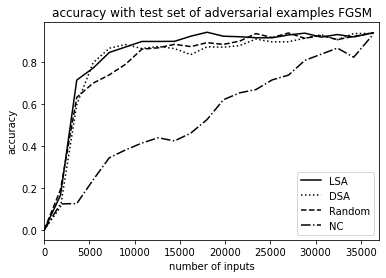

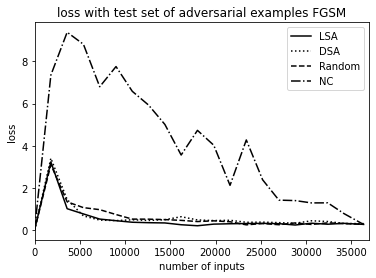

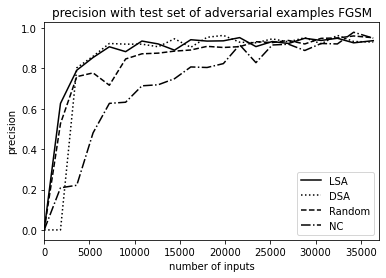

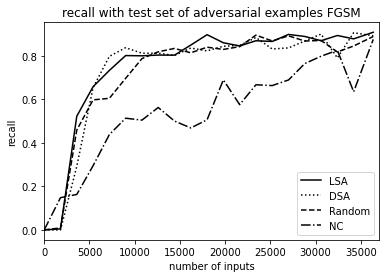

In [39]:
#configuration 1
"""
6) Incremental guided retraining starting from the original model using only the new adversarial inputs.
Incremental training, starting with the previous trained model. Using at each iteration a subset of the new inputs.
"""
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#metric = "accuracy" # accuracy loss
my_metrics =["accuracy","loss","precision","recall"]

for metric in my_metrics:
    plt.clf()
    plt.plot(n_inputs,df_evaluate_lsa_0[metric],colors[0],linestyle=linestyles[0])
    plt.plot(n_inputs,df_evaluate_dsa_0[metric],colors[1],linestyle=linestyles[1])
    plt.plot(n_inputs,df_evaluate_random_0[metric],colors[2],linestyle=linestyles[2])
    plt.plot(n_inputs,df_evaluate_nc_0[metric],colors[3],linestyle=linestyles[3])


    legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



    plt.legend(handles=legend_elements)#
    plt.title(metric + " with test set of adversarial examples FGSM")
    plt.xlim([0, 37000])
    #plt.ylim([0, 1])
    plt.xlabel('number of inputs')
    plt.ylabel(metric)
    plt.savefig("gtsrb_c1_"+metric + "_0.svg")
    plt.show()

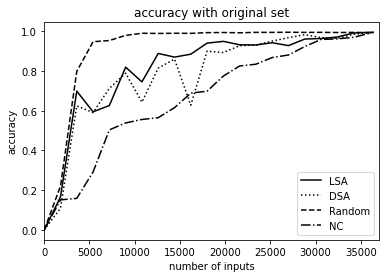

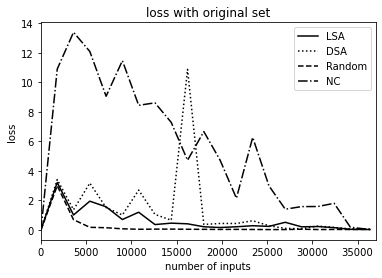

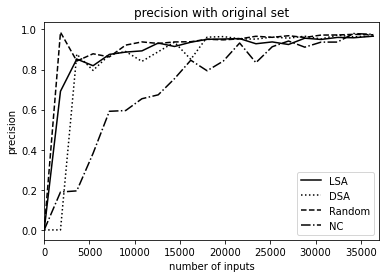

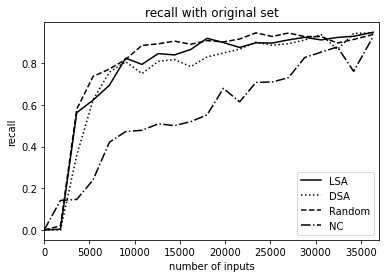

In [40]:
#configuration 1
"""
6) Incremental guided retraining starting from the original model using only the new adversarial inputs.
Incremental training, starting with the previous trained model. Using at each iteration a subset of the new inputs.
"""
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

my_metrics =["accuracy","loss","precision","recall"]

for metric in my_metrics:
    
#metric = "accuracy" # accuracy loss
    plt.clf()
    plt.plot(n_inputs,df_evaluate_lsa_1[metric],colors[0],linestyle=linestyles[0])
    plt.plot(n_inputs,df_evaluate_dsa_1[metric],colors[1],linestyle=linestyles[1])
    plt.plot(n_inputs,df_evaluate_random_1[metric],colors[2],linestyle=linestyles[2])
    plt.plot(n_inputs,df_evaluate_nc_1[metric],colors[3],linestyle=linestyles[3])

    legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



    plt.legend(handles=legend_elements)#
    plt.title(metric + " with original set")
    plt.xlim([0, 37000])
    #plt.ylim([0, 1])
    plt.xlabel('number of inputs')
    plt.ylabel(metric)
    plt.savefig("gtsrb_c1_"+metric + "_1.svg")
    plt.show()

36366 0.9668620824813843
36366 0.9653326570987701
27000 0.966352254152298
36366 0.9629110395908356


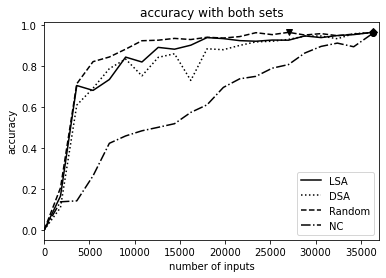

In [41]:
#adversarial jsma test set
#configuration 3
"""
6) Incremental guided retraining starting from the original model using only the new adversarial inputs.
Incremental training, starting with the previous trained model. Using at each iteration a subset of the new inputs.
"""
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.plot(n_inputs,accuracy_lsa_3,colors[0],linestyle=linestyles[0])
plt.plot(n_inputs,accuracy_dsa_3,colors[1],linestyle=linestyles[1])
plt.plot(n_inputs,accuracy_random_3,colors[2],linestyle=linestyles[2])
plt.plot(n_inputs,accuracy_nc_3,colors[3],linestyle=linestyles[3])


legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



plt.legend(handles=legend_elements)#
plt.title("accuracy with both sets")

print(n_inputs[np.argmax(accuracy_lsa_3)],accuracy_lsa_3.max())
print(n_inputs[np.argmax(accuracy_dsa_3)],accuracy_dsa_3.max())
print(n_inputs[np.argmax(accuracy_random_3)],accuracy_random_3.max())
print(n_inputs[np.argmax(accuracy_nc_3)],accuracy_nc_3.max())

plt.plot(n_inputs[np.argmax(accuracy_lsa_3)],accuracy_lsa_3.max(),'-kD')
plt.plot(n_inputs[np.argmax(accuracy_dsa_3)],accuracy_dsa_3.max(),'-ko')
plt.plot(n_inputs[np.argmax(accuracy_random_3)],accuracy_random_3.max(),'-kv')
plt.plot(n_inputs[np.argmax(accuracy_nc_3)],accuracy_nc_3.max(),'-kp')

plt.xlabel('number of inputs')
plt.ylabel('accuracy')
plt.xlim([0, 37000])
#plt.ylim([0, 1])

plt.savefig("gtsrb_c1_"+"accuracy" + "_both.svg")

plt.show()

## Saving models

In [16]:
new_model_lsa_dir  = "D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2"
i=0

for model in models_lsa:
    model.save(new_model_lsa_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_lsa_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gts

In [17]:
new_model_dsa_dir  = "D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2"

i=0
for model in models_dsa:
    model.save(new_model_dsa_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_dsa_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gts

In [18]:
new_model_random_dir  = "D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2"

i=0
for model in models_random:
    model.save(new_model_random_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_random_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/mo

In [19]:
new_model_nc_dir  = "D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2"

i=0
for model in models_nc:
    model.save(new_model_nc_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model_c1_sep_nc_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C1/gtsrb_model